# Jerash Data Analysis

**Date:** 10/03/2020

**Creator:** Iza Romanowska

**Context:** Pottery data analysis from the site of Jerash, Jordan. Excavations conducted by the joint Danish-German team under the leadership of prof. Rubina Raja and prof. Achim lichtenberger. 

**Type of data:** Pottery counts + associated parameters

**Chronology:** Roman to Late Antiquity

**Version:** 3.0, all data included.

**Files necessary to run the analysis:** site data: 'data.csv', list of topsoil and disturbed contexts: 'topsoil.xlsx', list of dated contexts: 'chronology.xlsx', list of contexts with Middle Islamic remains "MI_layers.xlsx"

This Jupyter notebook constitutes the Supplementary Information C, of the following publication: ...

Toggle the button above to hide/display the code.

In [1]:
# notebook setup
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('ggplot')
from IPython.display import display
from IPython.display import Image
#sns.set_palette('Spectral')
sns.set(palette = 'Spectral', font_scale = 1)

## Data Preparation

### Data cleaning

Remove all columns that are entirely empty and print the summary of the data types.

In [2]:
df = pd.read_csv('data.csv', delimiter = ';')
# there are a few columns with no values
df = df.dropna(axis=1, how='all')
#print(df1.columns.difference(df.columns)) # check columns that have no values

In [3]:
### Sanity checks, run on all new data files
df.head()
df.info()
#df[df.WareTypeID.isnull() == 1]
#df[df.Local.isnull() == 1]
#df.columns
#print(len(df))
#df.Trench.unique()
#df[df['EvidenceID'] == 1]
#print(len(df[df.Evidence =='0']))
#df.Evidence.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14861 entries, 0 to 14860
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Trench          14861 non-null  object 
 1   TrenchID        14794 non-null  float64
 2   Evidence        14861 non-null  object 
 3   EvidenceID      14794 non-null  float64
 4   Find            14861 non-null  object 
 5   Group           14861 non-null  object 
 6   GroupID         14861 non-null  int64  
 7   SG1             14861 non-null  object 
 8   SG1ID           14861 non-null  int64  
 9   SG2             14845 non-null  object 
 10  SG2ID           14844 non-null  float64
 11  SG3             9428 non-null   object 
 12  SG3ID           9428 non-null   float64
 13  SG4             2069 non-null   object 
 14  SG4ID           2069 non-null   float64
 15  SG5             586 non-null    object 
 16  SG5ID           586 non-null    float64
 17  AmountKept      14861 non-null 

In [4]:
print('Total number of artefacts: ', df.AmountSum.sum())
print('Number of retained artefacts: ', df.AmountKept.sum())
print('Number of trenches: ', len(df.Trench.unique()))
print('Number of unique Evidences: ', df.groupby('Trench')['Evidence'].unique().apply(len).sum())
#print(df.head())
#print(df.columns)
#print(df.PartOfObject.unique())

Total number of artefacts:  758833
Number of retained artefacts:  8537
Number of trenches:  29
Number of unique Evidences:  793


#### Remove the topsoil and any disturbed contexts 

In [5]:
topsoil = pd.read_excel('topsoil.xlsx', index_col = 'Trench')
# tidy up to get rid of funny values 
topsoil['Top soil'].loc['B'] = '1, 2, 54' # removed extra words
topsoil['Top soil'].loc['R'] = '1, 2' # moved 1 to here
#topsoil['Top soil'].loc['M'] = '0' # replaced nan with
topsoil['Top soil'] = topsoil['Top soil'].astype('str').str.split(', ')
topsoil = topsoil['Top soil']
topsoil = topsoil.to_dict()

#not all trenches are in the list of topsoils, so we'll just add them manually
for i in (set(df.Trench.unique()) - set(topsoil.keys())):
    topsoil[i] = [""]
#print(topsoil)


In [6]:
print ('number of rows original file: ', len(df))
df_surf = df[~df.Evidence.isin(['0'])]
print ('number of rows without evidence 0: ',len(df_surf))

# create a new data frame with the same column types
df_nots = pd.DataFrame(columns = df.columns).astype(df.dtypes.to_dict())

# iterate through the topsoil file and remove all disturbed contexts
for key,values in topsoil.items():  
    dummydf = df_surf[df_surf['Trench'] == key]          # for each trench
    dummydf = dummydf[~dummydf['Evidence'].isin(values)] # keep all rows except the topsoil
    df_nots = pd.concat([df_nots,dummydf])

# it follows the list of topsoils so we order the index back 
df_nots = df_nots.sort_index()
print('number of rows after all topsoil layers removed: ',len(df_nots))

# check for the trench names - in case some trenches were missing from the topsoil doc
#print(set(df.Trench.unique())- set(df_nots.Trench.unique()))
# Remove rows where 'Evidence' is 'clean' or 'mix'
mix = ['Clean', 'mix', 'Mix', 'Surfa']
df_clean = df_nots[~df_nots['Evidence'].isin(mix)]

print('number of rows after "Clean" and "mix" layers removed: ',len(df_clean))
print('The difference: ',len(df)-len(df_clean))
print('Amount of pottery. Total for the site: ', df.AmountSum.sum())
print('Amount of pottery. Topsoil removed: ',df_clean.AmountSum.sum())
print('The difference: ', df.AmountSum.sum()-df_clean.AmountSum.sum())


number of rows original file:  14861
number of rows without evidence 0:  14624
number of rows after all topsoil layers removed:  13388
number of rows after "Clean" and "mix" layers removed:  13308
The difference:  1553
Amount of pottery. Total for the site:  758833
Amount of pottery. Topsoil removed:  641941
The difference:  116892


In [7]:
"""
#### Visual check on the data after the topsoil has been removed, remove quotes to run
df_check = df.groupby('Trench')['Evidence'].unique().reset_index()
df_check['Length_original'] = df_check['Evidence'].str.len()
df_check1 = df_clean.groupby('Trench')['Evidence'].unique().reset_index()
df_check1['Length_cleaned'] = df_check1['Evidence'].str.len()
df_check2 = pd.merge(df_check, df_check1, left_on = 'Trench', right_on ='Trench', how = 'outer')
#df_check2.info()
df_check2.Evidence_y.replace(np.NaN, '[]', inplace=True)

df_check2['differences'] = [list(set(a) - (set(b))) for a, b in zip(df_check2.Evidence_x, df_check2.Evidence_y)]
df_check2['original_topsoil'] = df_check2['Trench'].map(topsoil)
df_check2
"""


"\n#### Visual check on the data after the topsoil has been removed, remove quotes to run\ndf_check = df.groupby('Trench')['Evidence'].unique().reset_index()\ndf_check['Length_original'] = df_check['Evidence'].str.len()\ndf_check1 = df_clean.groupby('Trench')['Evidence'].unique().reset_index()\ndf_check1['Length_cleaned'] = df_check1['Evidence'].str.len()\ndf_check2 = pd.merge(df_check, df_check1, left_on = 'Trench', right_on ='Trench', how = 'outer')\n#df_check2.info()\ndf_check2.Evidence_y.replace(np.NaN, '[]', inplace=True)\n\ndf_check2['differences'] = [list(set(a) - (set(b))) for a, b in zip(df_check2.Evidence_x, df_check2.Evidence_y)]\ndf_check2['original_topsoil'] = df_check2['Trench'].map(topsoil)\ndf_check2\n"

In [8]:
#The highest values are worth checking because a typo in a digit can have significant repercussions for the analysis. Here are the top 10. 
#df[['Trench', 'Evidence', 'Find', 'AmountSum']].sort_values(by = 'AmountSum').tail(10)

#### Percentage of material kept vs dumped in each trench

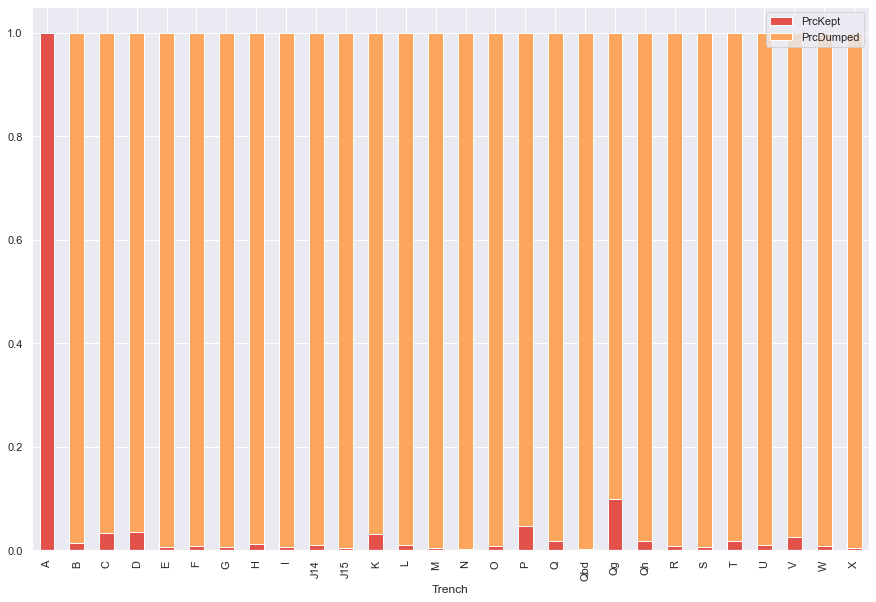

In [9]:
df_kept = df_clean.groupby('Trench')[['AmountKept', 'AmountDumped', 'AmountSum']].sum()
df_kept['PrcKept'] = df_kept['AmountKept'] / df_kept['AmountSum']
df_kept['PrcDumped']= df_kept['AmountDumped'] / df_kept['AmountSum']
df_kept[['PrcKept', 'PrcDumped']].plot(kind = 'bar', stacked = 'true', figsize = (15, 10))

## Distribution of archaeological material within archaeological units

### Amount of material per trench

This is figure 3 in Romanowska et al. 2021. Trends in Ceramic Assemblages from the Northwest Quarter of Gerasa/Jerash, Jordan.

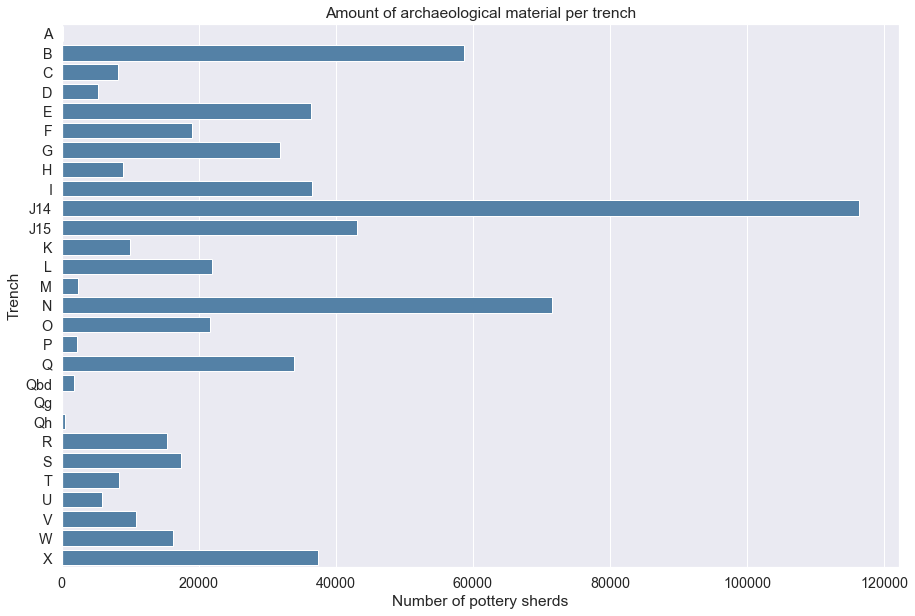

In [10]:
sns.set(palette = 'Spectral', font_scale = 1.3)
figure = plt.figure(figsize=(15,10))

ax = sns.barplot(y = 'Trench', 
                 x = 'AmountSum', 
                 data = df_clean, 
                 estimator= sum, 
                 ci = None, 
                 color = 'steelblue',
                 order = sorted(df_clean.Trench.unique().tolist())) # order alphabetically
ax.set(xlabel='Number of pottery sherds', ylabel = 'Trench', title = 'Amount of archaeological material per trench') 
plt.savefig('figures/3.png', dpi = 600)

In [11]:
df_clean.groupby(['Trench'], as_index = False)['AmountSum'].sum()#.T # .T to see the table horizontally

,Trench,AmountSum
0,A,212
1,B,58751
2,C,8232
3,D,5291
4,E,36327
5,F,19015
6,G,31898
7,H,8983
8,I,36573
9,J14,116316


### Amount of material per Evidence

Most contexts produced only a few artefacts (1-2) and the vast majority under 20 but there are some contexts with thousends of pottery sherds. 

,AmountKept,AmountDumped,AmountSum
count,13308.000000,13308.000000,13308.000000
mean,0.496243,47.740983,48.237226
std,3.315626,342.176696,342.123514
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000
50%,0.000000,2.000000,2.000000
75%,0.000000,11.000000,11.000000
max,226.000000,13873.000000,13873.000000


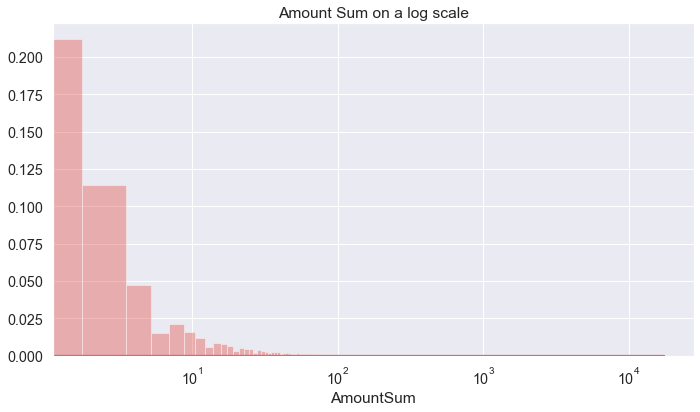

In [12]:
display(df_clean[['AmountKept', 'AmountDumped', 'AmountSum']].describe())
fig, ax =plt.subplots( figsize = (10,6))

# Arch material on a log scale
sns.distplot(df['AmountSum'].dropna(),  bins = 10000)
ax.set_title('Amount Sum on a log scale')
ax.set_xscale("log")

# Tidy up the layout
plt.tight_layout()

### Number of evidences (archaeological contexts) vs amount of material in a trench
This shows trenches with higher number of 'large' evidences. 

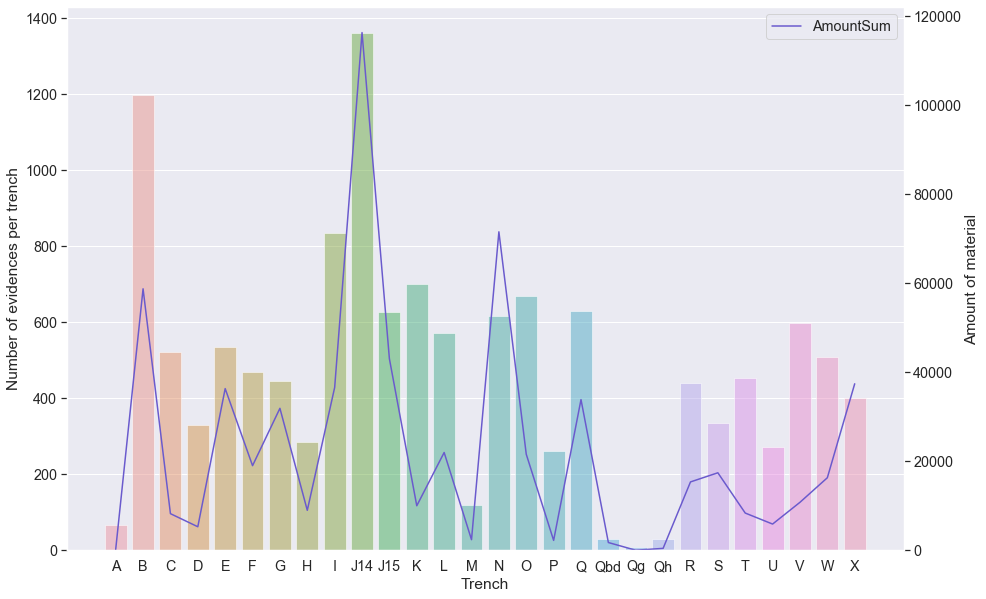

In [13]:
tr1 = df_clean.groupby('Trench').size().reset_index(name ='No_of_Evidences')
tr2 = df_clean.groupby(['Trench'], as_index = False)['AmountSum'].sum()
trs = tr1.merge(tr2, right_on = 'Trench', left_on ='Trench')
#display(trs)

fig, ax1 = plt.subplots(figsize = (15,10))
sns.barplot(y = trs.No_of_Evidences, x = 'Trench', data=trs,  ax = ax1, alpha = 0.5)
ax1.set_ylabel('Number of evidences per trench')

ax2 = ax1.twinx()
trs.plot(y = 'AmountSum', x = 'Trench', color = 'slateblue',  ax = ax2)
ax2.set_ylabel('Amount of material')
ax2.set_ylim(0, None)
ax2.grid(False)


***Observation: *** The amount of material coming from different trenches varies significantly but the number of evidences and the amount of material are roughly correlated. All analysis should be done on absolute counts and on frequencies calculated for each trench. 
The following trenches have some Evidences with high amount of material in respect to the number of Evidences: J14, X and N.

This is figure 4 in Romanowska et al. 2021. Trends in Ceramic Assemblages from the Northwest Quarter of Gerasa/Jerash, Jordan.

<ipython-input-14-b1857fbcf20f>:16: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)


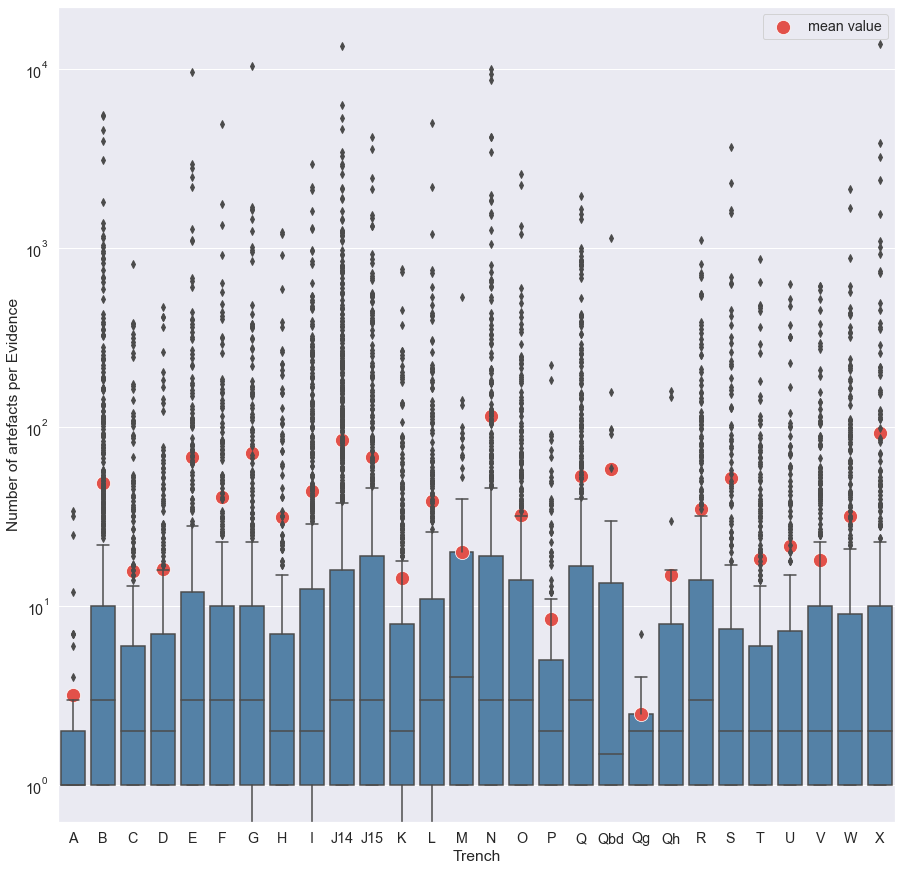

In [14]:
sns.set(palette = 'Spectral', font_scale = 1.3)
ax, fig = plt.subplots(figsize=(15,15))
order = sorted(df_clean.Trench.unique().tolist())
ax = sns.boxplot(x = "Trench", 
                 y = "AmountSum", 
                 data = df_clean,
                 color = 'steelblue',
                 order = order)
ax = sns.scatterplot(x = order, 
                     y=df_clean.groupby("Trench")["AmountSum"].mean(), 
                     s = 200, label = 'mean value')


ax.set_yscale("log")
ax.set_ylabel("Number of artefacts per Evidence")
ax.set_ylim(0, None)
plt.savefig('figures/4.png', dpi = 600)

In [15]:
print("Maxium number of artefacts per Evidence: ", df_clean.AmountSum.max())
print('And the Evidence with max artefacts is: ') 
display(df_clean.loc[df_clean['AmountSum'] == df_clean.AmountSum.max()])
print("Minimum number of artefacts per Evidence: ", df_clean.AmountSum.min())
print("Average number of artefacts per Evidence: ", df_clean.AmountSum.mean())
print("Median number of artefacts per Evidence: ", df_clean.AmountSum.median())

Maxium number of artefacts per Evidence:  13873
And the Evidence with max artefacts is: 


,Trench,TrenchID,Evidence,EvidenceID,Find,Group,GroupID,SG1,SG1ID,SG2,...,SG5ID,AmountKept,AmountDumped,AmountSum,PartOfObject,PartOfObjectID,WareType,WareTypeID,Local,LocalID
13180,X,26.0,2,816.0,ds_21,Ceramics,1,Pottery,2,Table Ware,...,NaN,0,13873,13873,Body,3.0,Plain,7.0,Local,1.0


Minimum number of artefacts per Evidence:  0
Average number of artefacts per Evidence:  48.23722572888488
Median number of artefacts per Evidence:  2.0


## Data Wrangling

Here we will prepare the data for analysis: 
1. subset it to pottery only;
2. flatten the typology to unique identifiers;
3. add chronology from a separate file;
4. test coherence.

### Subset the data to pottery

In [16]:
# Subset data to ceramics only
print('Total number of data entities', len(df_clean))
df_pot = df_clean[df_clean['Group'] == 'Ceramics']
print('Total number of all ceramics: ', len(df_pot))
# Subset data to pottery only
df_pot = df_pot[df_pot['SG1'] == 'Pottery']
print('Total number of pottery only: ', len(df_pot))
df_pot.head()

Total number of data entities 13308
Total number of all ceramics:  13308
Total number of pottery only:  13278


,Trench,TrenchID,Evidence,EvidenceID,Find,Group,GroupID,SG1,SG1ID,SG2,...,SG5ID,AmountKept,AmountDumped,AmountSum,PartOfObject,PartOfObjectID,WareType,WareTypeID,Local,LocalID
0,P,1.0,102,1.0,ds_1,Ceramics,1,Pottery,2,Table Ware,...,NaN,0,1,1,Rim,1.0,Plain,7.0,Local,1.0
1,P,1.0,102,1.0,ds_2,Ceramics,1,Pottery,2,Table Ware,...,NaN,0,3,3,Body,3.0,Plain,7.0,Local,1.0
2,P,1.0,102,1.0,ds_3,Ceramics,1,Pottery,2,Table Ware,...,NaN,0,1,1,Handle,7.0,Local,25.0,Local,1.0
3,P,1.0,101,2.0,ds_1,Ceramics,1,Pottery,2,Table Ware,...,NaN,0,1,1,Rim,1.0,Local,25.0,Local,1.0
4,P,1.0,101,2.0,ds_2,Ceramics,1,Pottery,2,Table Ware,...,NaN,0,4,4,Body,3.0,Local,25.0,Local,1.0


### Give each find type a unique type identifier 
We add all SGs into one number to provide a unique identifier for each pottery type. We can use different thresholding levels (e.g., only SG1-3) or classify each type separately.

In [17]:
df_pot['Type'] = (df[['SG1ID', 'SG2ID','SG3ID', 'SG4ID', 'SG5ID']]
                  .fillna(0)
                  .astype('int')
                  .astype('str')
                  .apply(lambda x: ''.join(x), axis=1))
# Use the following line to check whether correct
#df_pot[['SG1ID', 'SG2ID','SG3ID', 'SG4ID', 'SG5ID', 'Type']].head(20)

df_pot['Type_verbose'] = (df[['SG1', 'SG2','SG3', 'SG4', 'SG5']]
                  .fillna('')
                  .astype('str')
                  .apply(lambda x: ', '.join(x), axis=1))

This is how it looks like. E.g., Type 25500 is SG2: 2 ('Pottery'), SG3: 5('Table Ware'), SG4: 5('Plain Ware'), SG5: 0 (no value), SG6: 0 (no value).

In [18]:
# Keep the pottery columns
col_names = ['Trench', 'Evidence', 'Find','AmountSum', 'WareType', 'Local', 'Type', 'Type_verbose']
df_pot = df_pot[col_names]
df_pot.head()

,Trench,Evidence,Find,AmountSum,WareType,Local,Type,Type_verbose
0,P,102,ds_1,1,Plain,Local,25500,"Pottery, Table Ware, Plain Ware, ,"
1,P,102,ds_2,3,Plain,Local,25500,"Pottery, Table Ware, Plain Ware, ,"
2,P,102,ds_3,1,Local,Local,25500,"Pottery, Table Ware, Plain Ware, ,"
3,P,101,ds_1,1,Local,Local,25500,"Pottery, Table Ware, Plain Ware, ,"
4,P,101,ds_2,4,Local,Local,25500,"Pottery, Table Ware, Plain Ware, ,"


### Collapse the Finds rows whilst summing up the AmountSum

In [19]:
df_pot = df_pot.groupby(['Trench','Evidence','Local', 'WareType', 'Type']).agg(
    {'AmountSum':'sum', 
     'Find':'first',
    # 'WareType':'first', 
    # 'Local':'first', 
    # 'Type':'first', 
     'Type_verbose':'first'}).reset_index()
print('Length original: ', len(df_clean), 'Length now: ', len(df_pot))
print('Sum AmountSum original: ',df_clean[df_clean['SG1'] == 'Pottery']['AmountSum'].sum(), 
      'Sum AmountSum now: ', df_pot.AmountSum.sum())
# check that although the length of the df changed the total amount of pottery was maintained
df_pot.head()

Length original:  13308 Length now:  5001
Sum AmountSum original:  641728 Sum AmountSum now:  641728


,Trench,Evidence,Local,WareType,Type,AmountSum,Find,Type_verbose
0,A,10,Local,Local,25400,1,ks_1,"Pottery, Table Ware, Fine Ware, ,"
1,A,10,Local,Red ware/Reddish Brown ware,25500,1,ks_2,"Pottery, Table Ware, Plain Ware, ,"
2,A,12,Local,Red ware/Reddish Brown ware,25500,8,ks_1,"Pottery, Table Ware, Plain Ware, ,"
3,A,13,Local,Local,25500,1,ks_7,"Pottery, Table Ware, Plain Ware, ,"
4,A,13,Local,Red ware/Reddish Brown ware,25500,5,ks_1,"Pottery, Table Ware, Plain Ware, ,"


### Add chronology
#### Read in the file, combine all Excel sheets together

In [20]:
# read file
xl = pd.ExcelFile('chronology.xlsx')
df_new = pd.DataFrame()
names = xl.sheet_names
count = 0

# collect data from all the sheets and combine together
for i in names:
    j = i[-1]
    if i == "2015 - Trench J": #trench J and trench Q are divided, we maintain that division
        j = "J15"
    if i == "2014 - Trench J":
        j = "J14"
    if i == "2015 - Trench Qg":
        j = "Qg"  
    if i == "2015 - Trench Qh":
        j = "Qh" 
    for y in df_pot.Trench.unique():
        
        if y in j:
           # print(y, j)
           
            df_temp = pd.read_excel('chronology.xlsx', 
                                    sheet_name = i, 
                                    skiprows=2, 
                                    header = 0, 
                                    convert_float = True, 
                                    na_values = '-')
            
            count += len(df_temp)

            df_temp.rename(columns={'Evidence no. ':'Evidence'},inplace=True)
            # here we autofill because there were many gaps
            df_temp.Evidence.fillna(method='ffill', inplace = True)
            df_temp['Evidence'] = df_temp['Evidence'].astype(int).astype(str)
            df_temp['Trench'] = j

            df_new = pd.concat([df_new, df_temp], ignore_index = True)

    
df_new.head()


,Evidence,Pottery,14C,Glass,Coin,Comments,Trench
0,1,NaN,NaN,NaN,R,Pottery Modern fill.,A
1,2,NaN,NaN,NaN,NaN,NaN,A
2,3,NaN,NaN,NaN,NaN,NaN,A
3,4,R,NaN,NaN,NaN,NaN,A
4,5,NaN,NaN,NaN,NaN,NaN,A


#### Sum up number of datings in each category (remove 'Comments')

In [21]:
df_new.drop(columns =['Comments']).groupby(['Trench', 'Evidence']).count().sum()#.sum()

Pottery    1241
14C          81
Glass       274
Coin        206
dtype: int64


#### Combine with the original data

In [22]:
# use this line if you want to have dating for each category summed up separately 
# eg. if AmountSum 10 and dating REB then R gets extra 10 and EB gets extra 10 
# you obviously end up with way more pottery than there actually is
#df_new.update(df_new[['Pottery','14C','Glass','Coin']].fillna(''))

# use this line if you want to have dating as it is, e.g., REB will stay REB. 
df_new = df_new.fillna('').groupby(['Trench','Evidence']).agg(
    {'Pottery': lambda col: ''.join (col) ,
     '14C': lambda col: ''.join(col),
     'Glass': lambda col: ''.join(col), 
     'Coin': lambda col: ''.join(col),
     'Comments': 'first'}).reset_index()

df_f = pd.merge(df_pot, df_new, on = ['Trench', 'Evidence'], how = 'left')

# a bit of housekeeping, order columns, replace empty cells with nans
columns = ['Trench', 'Evidence','AmountSum', 'Type', 'Type_verbose', 'Local','WareType','14C','Coin', 'Glass', 'Pottery', 'Comments']
df_f= df_f[columns]

from collections import OrderedDict
for i in columns[7:-1]:
    df_f[i] = df_f[i].fillna('').map(lambda x: ''.join(OrderedDict.fromkeys(x).keys()), na_action=None)

df_f = df_f.replace(['', '?'], np.nan)
df_f = df_f.replace('BEIR', 'RBEI')

#Check that the totals are correct (if you use the first method they' obviously wont)
print('Checks for coherence, all values should be the same unless the first method was used')
print('Sum AmountSum original: ',df_clean[df_clean['SG1'] == 'Pottery']['AmountSum'].sum(), 'Sum AmountSum pot: ', df_pot.AmountSum.sum())
print('Sum AmountSum original: ',df_clean[df_clean['SG1'] == 'Pottery']['AmountSum'].sum(), 'Sum AmountSum pot with chrono: ', df_f.AmountSum.sum())


Checks for coherence, all values should be the same unless the first method was used
Sum AmountSum original:  641728 Sum AmountSum pot:  641728
Sum AmountSum original:  641728 Sum AmountSum pot with chrono:  641728


If same values then all dimensions of data have been preserved.

Dating convention: 
R - Roman
B - Bizantine
EI - Early Islamic

Plus combinations when one context was dated to multiple periods:

### Add Middle Islamic dating
This chronology comes from two sources: A list of Middle Islamic contexts and a list of Evidences where Middle Islamic pottery has been found mixed with other types

In [23]:
# first contexts where MI pottery is present
MI_contexts = df_f[df_f['WareType'].isin(["Unpainted Mamluk", "HMGPW"])]
# we do it this way to ensure that the MI dating is on all instances of that archaeological context
MI_contexts["MI_pot"] = 'EIMI'
MI_contexts = MI_contexts[['Trench', 'Evidence', 'MI_pot']]
df_f = pd.merge(df_f, MI_contexts, how ='left', on = ['Trench', 'Evidence']) 


<ipython-input-23-6c823f289999>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MI_contexts["MI_pot"] = 'EIMI'


In [24]:
# data with MI contexts
MI = pd.read_csv('MI_layers.csv', dtype = object)
df_MI = pd.merge(df_f, MI, how = 'left', on = ['Trench', 'Evidence'])
df_MI["MI"].fillna(df_MI["MI_pot"], inplace=True) # MI contexts stay unchanged, mixed contexts are added
df_f = df_MI.drop('MI_pot', axis = 1)

## Exploratory Data Analysis


#### Setup of color palettes

['R', 'RB', 'B', 'BEI', 'EI', 'REI', 'RBEI']


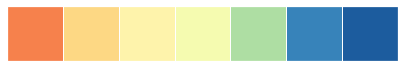

In [25]:
order = [ 'R', 'RB','B', 'BEI',  'EI', 'REI', 'RBEI']

pal_chrono = sns.color_palette('Spectral', 12)[2:3] + sns.color_palette('Spectral', 12)[4:7]+sns.color_palette('Spectral', 12)[8:9]+sns.color_palette('RdBu', 11)[-2:]
print(order)
sns.palplot(pal_chrono)
chrono_pal_dict = dict(zip(order, pal_chrono))



   R      RB      B    BEI     EI    EIMI   MI    RBEI  BEIMI RBEIMI


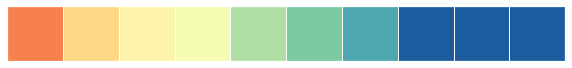

In [26]:
all_order = ['R', 'RB', 'B', 'BEI', 'EI', 'EIMI', 'MI', 'RBEI','BEIMI', 'RBEIMI']
#sns.palplot(sns.color_palette('Spectral', 12))
pal_chrono_all = sns.color_palette('Spectral', 12)[2:3] + sns.color_palette('Spectral', 12)[4:7]+sns.color_palette('Spectral', 12)[8:11]+sns.color_palette('RdBu', 11)[-1:] * 3
print ( '   R', '     RB', '     B',  '   BEI', '    EI',  '   EIMI', '  MI',  '   RBEI',' BEIMI', 'RBEIMI',)
sns.palplot(pal_chrono_all)
all_chrono_pal_dict = dict(zip(all_order, pal_chrono_all))

### Distribution of chronology

Please note that chronology that was not classified (e.g., exact dates) was removed. 

X-axis: chronology. Y-axis: number of artefacts.


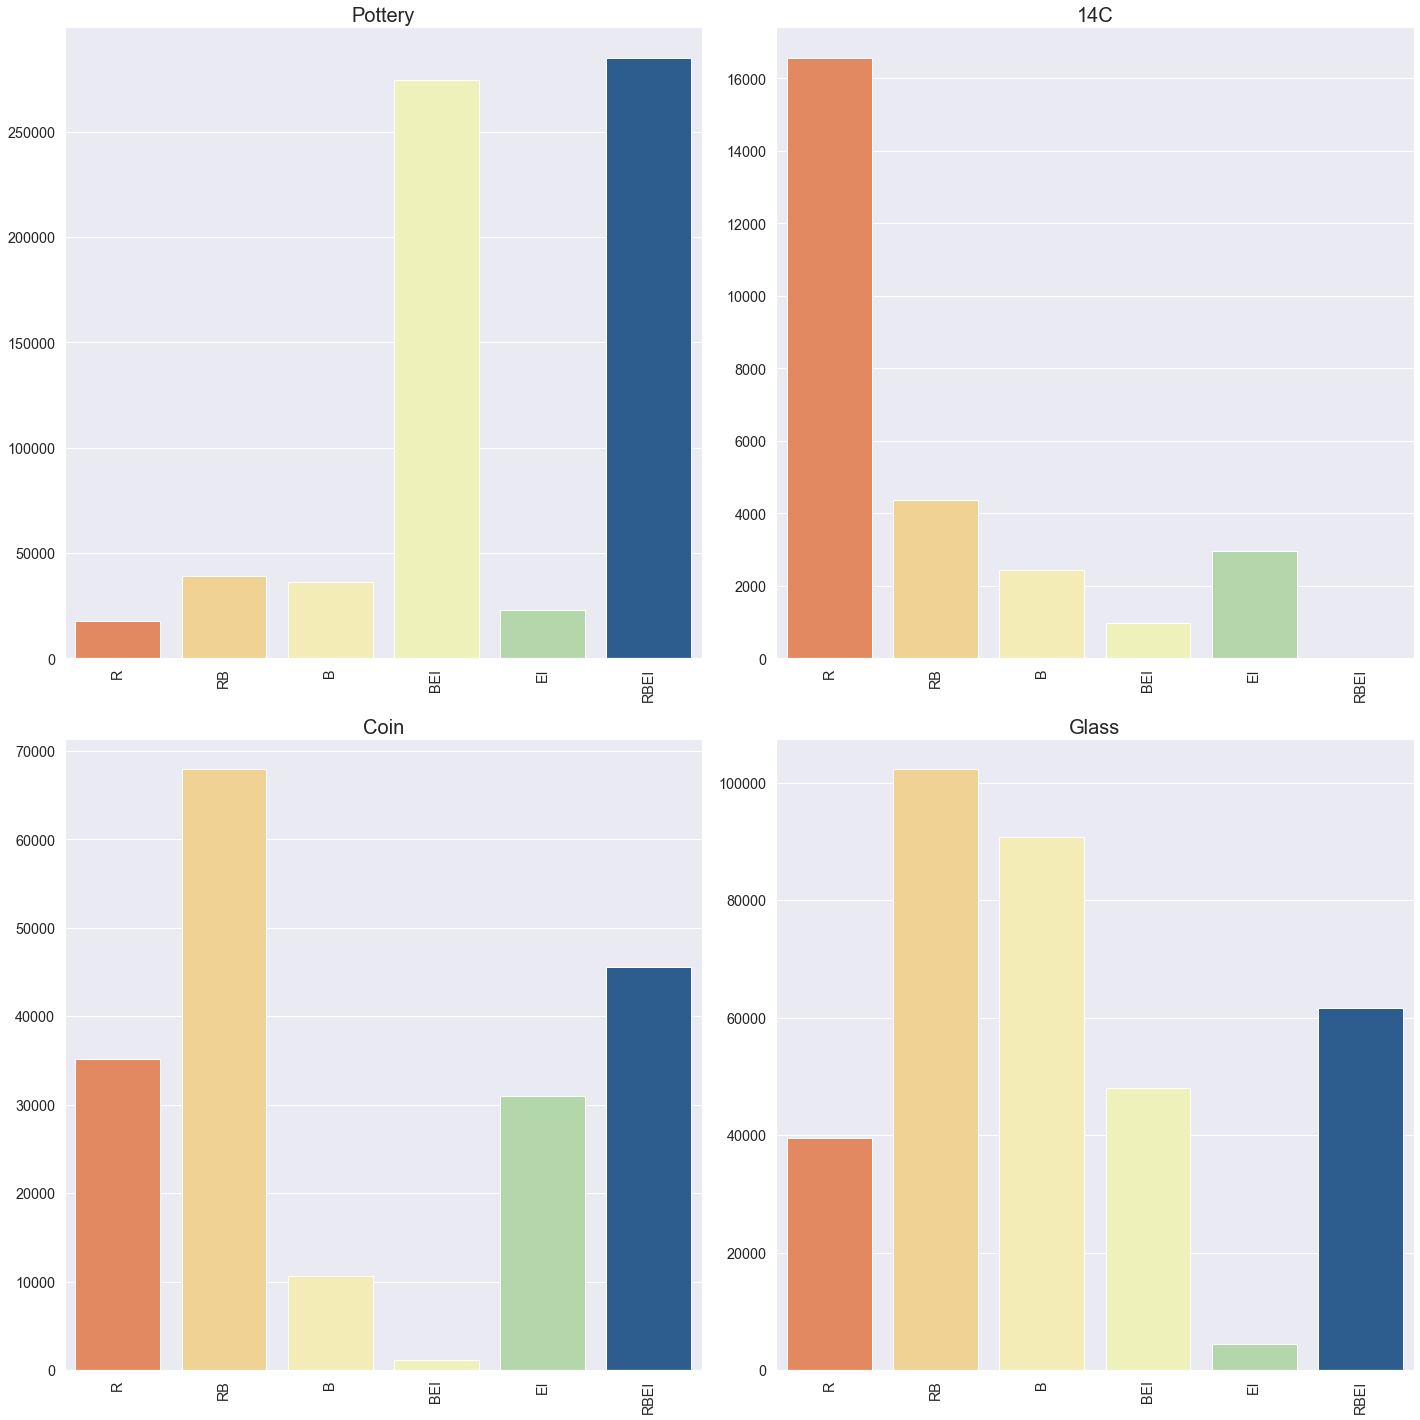

In [27]:
plt.figure(figsize = (20,20))
order_noMI = [ 'R', 'RB', 'B', 'BEI',  'EI', 'RBEI']
pl = 1
dating_types = ['Pottery','14C', 'Coin', 'Glass']
for i in dating_types:
    plt.subplot(2,2, pl)
    ax = sns.barplot(x = i, y = 'AmountSum', estimator = sum, data = df_f, ci = None, order = order_noMI, palette = all_chrono_pal_dict)
    ax.set(xlabel='', ylabel = '') 
    plt.xticks(rotation = 90)
    plt.title(i, fontsize=20)

    plt.tight_layout()
    pl+=1

#plt.savefig('figures/chronology.png', dpi = 300)


### Chronology - evidences with wide chronology removed ('REI' and 'RBEI')

X-axis: chronology. Y-axis: number of artefacts

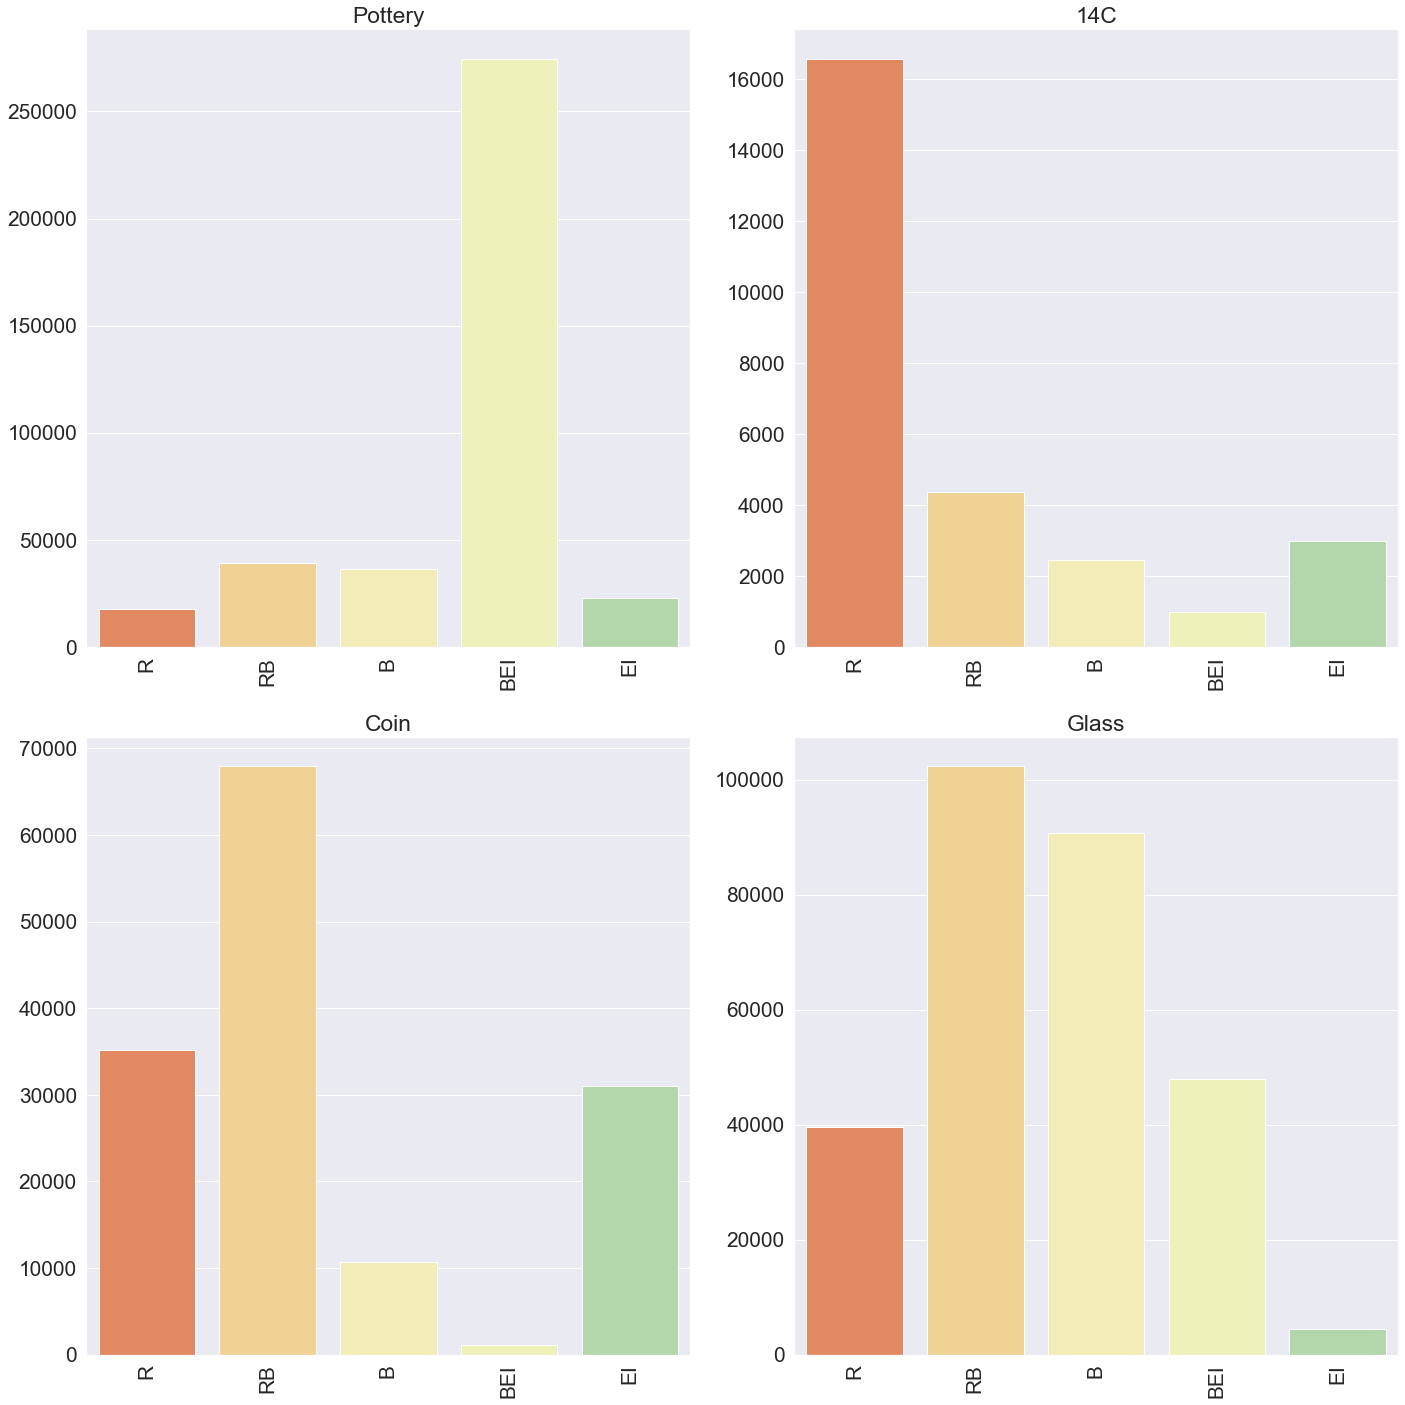

In [28]:
sns.set(font_scale = 1.9)
plt.figure(figsize = (20,20))
pl = 1
order_small = [ 'R', 'RB', 'B', 'BEI',  'EI']
dating_types = ['Pottery','14C', 'Coin', 'Glass']
for i in dating_types:
    plt.subplot(2,2, pl)
    ax = sns.barplot(x = i, y = 'AmountSum', estimator = sum, data = df_f, ci = None, order = order_small, palette = chrono_pal_dict)
    ax.set(xlabel='', ylabel = '') 
    plt.xticks(rotation = 90)
    plt.title(i)
    plt.tight_layout()
    pl+=1
#plt.savefig('figures/CiC_chronology.png', dpi = 600)


In [29]:
# This shows the total number of pieces that has been dated using pottery and that do not have a very long chrology - i.e. RBEI
df_dated = df_f[df_f['Pottery'].isin(order_small)]
df_dated.groupby('Pottery')['AmountSum'].sum()#.sum()


Pottery
B       36400
BEI    274690
EI      22919
R       17690
RB      39352
Name: AmountSum, dtype: int64

### Number of pottery sherds dated with each method per period

This is figure 6 in Romanowska et al. 2021. Trends in Ceramic Assemblages from the Northwest Quarter of Gerasa/Jerash, Jordan.

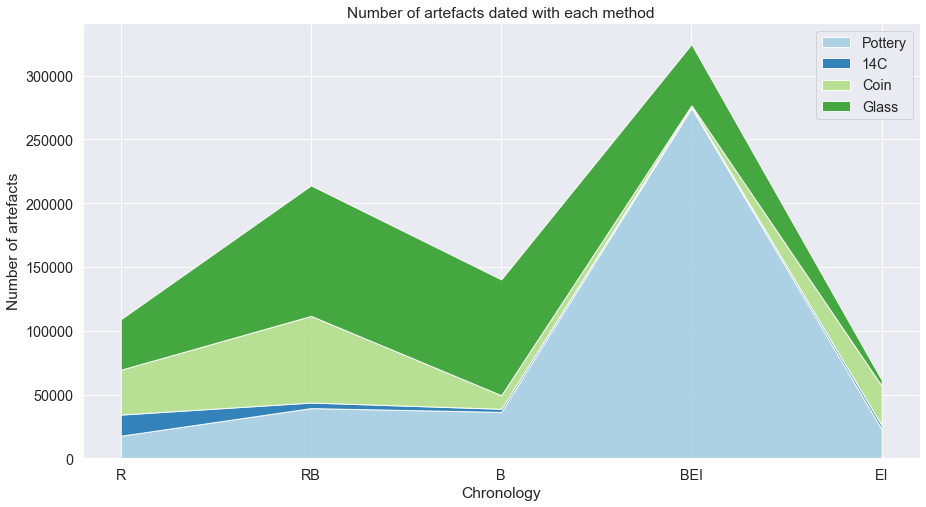

In [30]:
sns.set(palette = 'Paired', font_scale = 1.3)

# Add up the number of artefacts dated to each period using each method
dating = []
for i in dating_types:
    df_dated = df_f[df_f[i].isin(order_small)]
 #   print(df_dated.groupby(i)['AmountSum'].sum()) #check the values
    dating.append(df_dated.groupby(i)['AmountSum'].sum().reindex(order).values)

# plot using stackplot
plt.figure(figsize=(15,8))
plt.stackplot(order,dating, labels=dating_types,  alpha=0.9 )
plt.legend(loc='upper right')
plt.xlabel('Chronology')
plt.ylabel('Number of artefacts')

plt.title('Number of artefacts dated with each method')

plt.savefig('figures/6.png', dpi = 600)
plt.show()

#### Combine chronology from all categiories

If different categories bring different chronological markers we merge them into a mixed context (e.g., RBEI).

In [31]:
def sort_crono(string):
    a = ""
    for i in ['R', 'B', 'EI', 'MI']:
        if i in string:

            a = a+i
    return a

In [32]:
all_dating_types = ['Pottery','14C', 'Coin', 'Glass', 'MI']
df_f['combined'] = df_f[all_dating_types].fillna('').apply(lambda row: ''.join(set(row.values.astype(str))), axis=1).apply(sort_crono)


In [33]:
# Some of the wider chronology need re-labeling. 
# E.g., If a context has both R and MI evidence then it should just be grouped as the widest chronology RBEIMI
chrono_dict = {"RBMI":"RBEIMI", "REI":"RBEI", "REIMI": "RBEIMI", "":"no dating"}
df_f['combined'] = df_f['combined'].replace(chrono_dict) 
df_f.groupby('combined')['AmountSum'].sum()
# this affects obly about 4000 artefacts

combined
B             32741
BEI          120627
BEIMI         46141
EI             4592
EIMI           1457
MI             1063
R             28004
RB            40910
RBEI         235862
RBEIMI       180075
no dating     23674
Name: AmountSum, dtype: int64

In [34]:
df_f['combined'].unique()

array(['RBEI', 'R', 'RBEIMI', 'RB', 'no dating', 'BEI', 'BEIMI', 'EI',
       'B', 'MI', 'EIMI'], dtype=object)

Text(0.5, 1.0, 'Dating of Artefacts using all Methods')

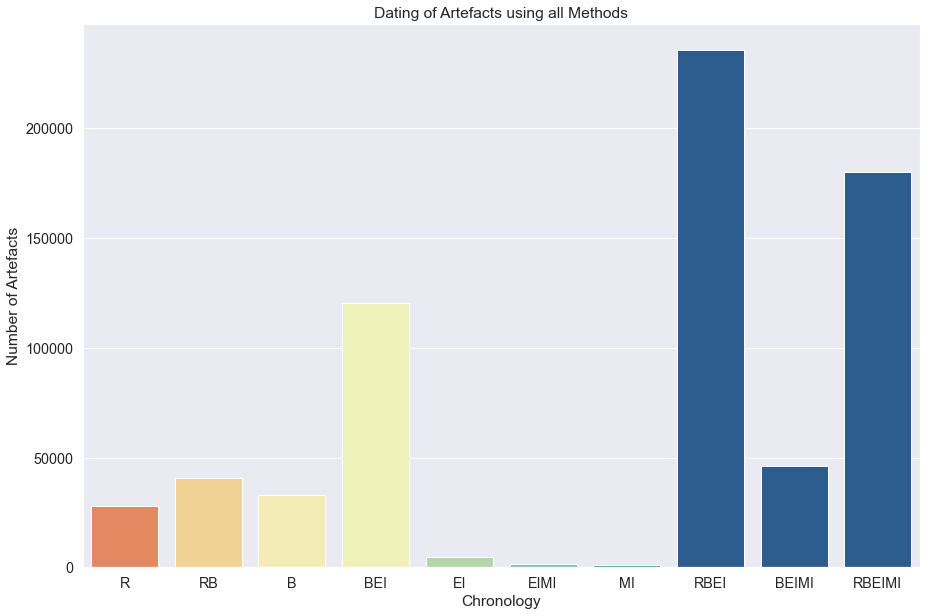

In [35]:
plt.figure(figsize=(15,10))
ax = sns.barplot(x = 'combined', y = 'AmountSum', estimator = sum, data = df_f, ci = None, order = all_order, palette = all_chrono_pal_dict)
ax.set_xlabel('Chronology')
ax.set_ylabel('Number of Artefacts')
ax.set_title('Dating of Artefacts using all Methods')

### Provenance of pottery (Local, Regional, Imported)

X-axis: number of artefacts; Y-axis: pottery provenance.

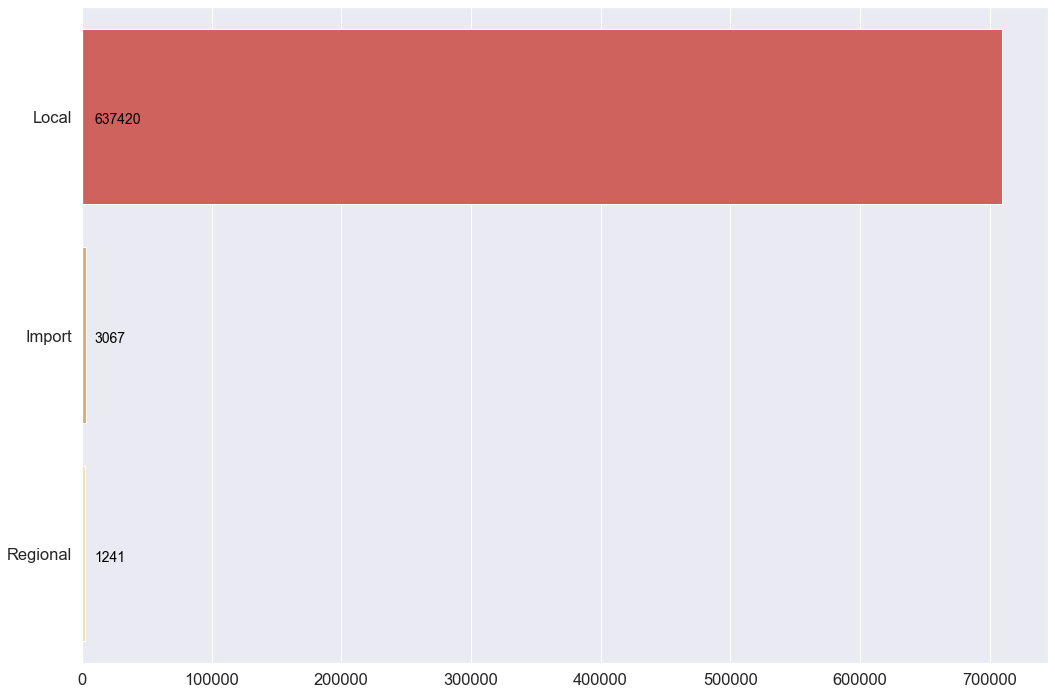

In [36]:
sns.set(palette = 'Spectral', font_scale = 1.5)
plt.figure(figsize = (15,10))

ax=sns.barplot(y = 'Local', 
               x = 'AmountSum', 
               data = df_f, 
               estimator= sum, 
               order = ['Local', 'Import', 'Regional'],
               ci = None)
                
ax.set(xlabel='', ylabel = '') 

a,b,c = [str(x) for x in  df_pot.groupby(['Local'])['AmountSum'].sum().sort_index()]

# correct the order of labels
a,b,c =  b,a,c

place = 0.035
for j in [a,b,c]:  
    plt.text(10000,place, j, fontsize = 14, color='black')
    place +=1
plt.tight_layout()
#plt.savefig('Local_total_large.png', dpi = 300)


In [37]:
totals = df_f.groupby(['Local'])['AmountSum'].sum()
pcts = totals.groupby(level=0).apply(lambda x:  x / float(sum(df_f.AmountSum))*100).to_frame()
combined = pd.merge (totals.to_frame(), pcts, left_index = True, right_index = True)
combined.rename(columns = {'AmountSum_x':'Amount Sum','AmountSum_y': 'Percentage'}, inplace=True)
display(combined)

,Amount Sum,Percentage
Local,,
Import,3261,0.455991
Local,709859,99.260710
Regional,2026,0.283299


### Provenance chronological distribution

#### Percentages of local/non-local pottery by dating type 

X-axis: Chronology; Y-axis: Number of artefacts. 

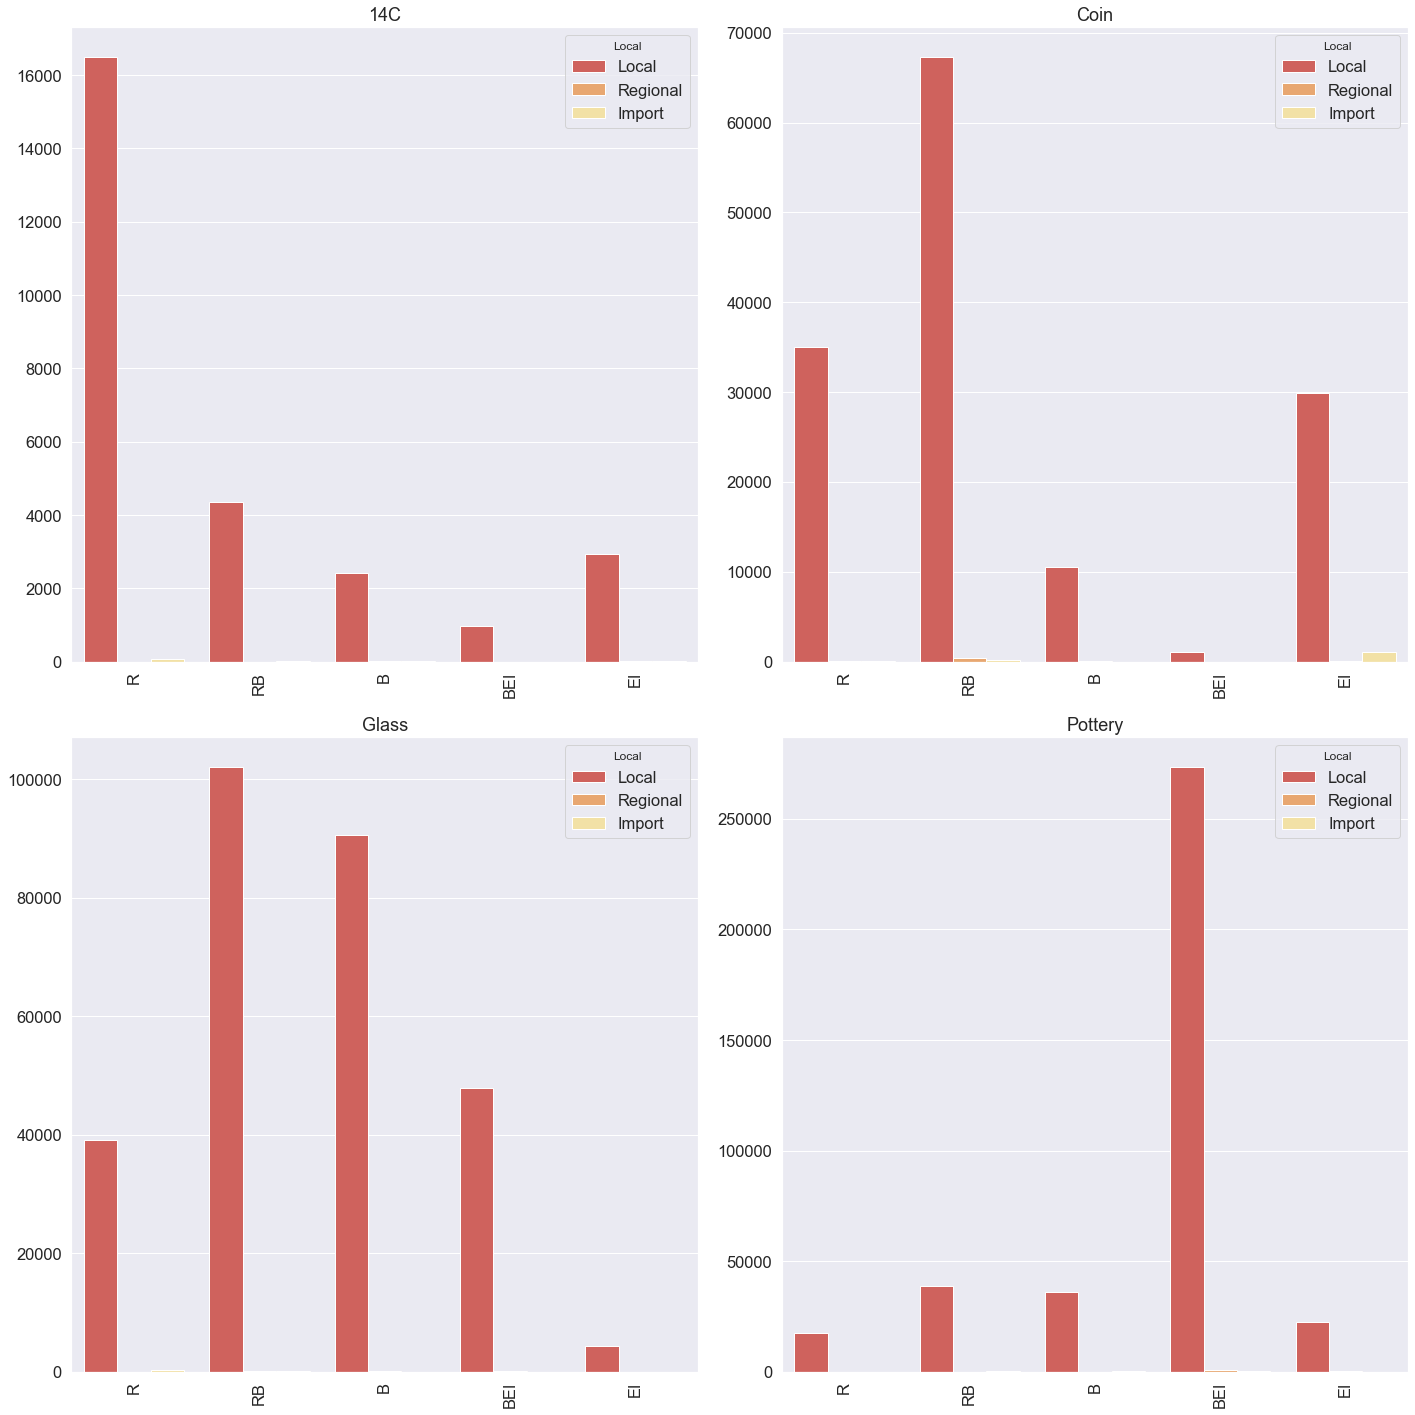

In [38]:
sns.set(palette = 'Spectral', font_scale = 1.5)
plt.figure(figsize = (20,20))
pl = 1
order = [ 'R', 'RB', 'B', 'BEI',  'EI']
for i in ['14C', 'Coin', 'Glass', 'Pottery']:
    plt.subplot(2,2, pl)
    ax = sns.barplot(x = i, y = 'AmountSum', estimator = sum, data = df_f, hue = 'Local', ci = None, order = order)
    ax.set(xlabel='', ylabel = '') 
    plt.xticks(rotation = 90)
    plt.title(i)
    plt.tight_layout()
    pl+=1
#plt.savefig('chronology.png')

In [39]:
for i in dating_types:
    
    pivot_df = df_f.pivot_table( columns='Local', index = i, values='AmountSum', aggfunc = 'sum')
#pivot_df = pivot_df.applymap(lambda x: x / x.sum())
    pivot_df['sum'] = pivot_df.sum(axis = 1)
    pivot_df.apply(lambda x: 100 * x / pivot_df['sum'])
    display(pivot_df)

Local,Import,Local,Regional,sum
Pottery,,,,
B,215,36184,1,36400
BEI,468,273315,907,274690
EI,25,22434,460,22919
R,92,17593,5,17690
RB,289,39059,4,39352
RBEI,1846,282771,577,285194
REI,4,1843,2,1849


Local,Import,Local,Regional,sum
14C,,,,
B,6.0,2424.0,11.0,2441.0
BEI,NaN,976.0,NaN,976.0
EI,25.0,2935.0,18.0,2978.0
R,80.0,16493.0,3.0,16576.0
RB,7.0,4350.0,2.0,4359.0


Local,Import,Local,Regional,sum
Coin,,,,
B,11.0,10564.0,70.0,10645.0
BEI,15.0,1078.0,NaN,1093.0
EI,1046.0,29906.0,56.0,31008.0
R,55.0,35070.0,51.0,35176.0
RB,179.0,67310.0,458.0,67947.0
RBEI,117.0,45170.0,250.0,45537.0
REI,15.0,18362.0,46.0,18423.0


Local,Import,Local,Regional,sum
Glass,,,,
.,NaN,88.0,NaN,88.0
B,71.0,90597.0,111.0,90779.0
BEI,56.0,47857.0,78.0,47991.0
EI,13.0,4453.0,5.0,4471.0
It isold(eJ16-Sc30)anrhgpy!,NaN,62.0,NaN,62.0
R,381.0,39177.0,41.0,39599.0
RB,195.0,102010.0,133.0,102338.0
RBEI,123.0,61114.0,431.0,61668.0


# Local/non-local distribution per period 

 X-axis: Chronology; Y-axis: number of artefacts. Please note that the y axis of the middle plot is on logarithmic scale.

In [40]:
pal99 = [(0.99715494040753561, 0.91180315263360245, 0.60107650903498655),(0.88535178777393309, 0.31903114186851211, 0.29042675893886966), (0.98731257208765866, 0.64736639753940783, 0.36424452133794688)]

def pic_maker(data):
   # print (data)
    sns.set(palette = 'Spectral', font_scale = 1.5)
    pal99 = [(0.99715494040753561, 0.91180315263360245, 0.60107650903498655),(0.88535178777393309, 0.31903114186851211, 0.29042675893886966), (0.98731257208765866, 0.64736639753940783, 0.36424452133794688)]
    #plt.figure(figsize = (15,15))
    
    order = [ 'R', 'RB', 'B', 'BEI',  'EI', 'RBEI']

    f, (ax1, ax2, ax3) = plt.subplots(1, 3,   figsize=(20,10))

    #Right graph
    ax1 = sns.barplot(x = data, y = 'AmountSum', hue = 'Local',data = df_f, estimator= sum, ci = None, ax = ax1, order = order)
    ax1.set(xlabel='', ylabel = '') 
    ax1.set_title (data + ' dating: absolute numbers')
    ax1.legend().set_title('')

    # Left graph
    ax2 = sns.barplot(x = data, y = 'AmountSum', hue = 'Local',data = df_f, estimator= sum, ci = None, ax = ax2, order = order)
    ax2.set(xlabel='', ylabel = '') 
    ax2.set_yscale('log')
    ax2.set_title ('Logarithmic scale')
    ax2.legend_.remove()
    
    freqs_evid = (df_f.groupby([data,'Local'])["AmountSum"]
                  .sum()                             # sum amounts per trench per evidence
                  .unstack()                         # crt the data frame
                  .T                                 # transpose
                  .apply(lambda x: x / x.sum())      # calculate frequencies per evidence
                  .T                                 # transpose back
               #   .loc[order]                       # this is not supported any more if any of the labels are missing
                  .plot(kind='bar',                  # plot
                      stacked=True, 
                      ax = ax3,
                   #   figsize = (20,10), 
                        legend = False,
                       color = pal99, 
                       ylim = (0,1.0), 
                  title = ""))
    ax3.set_title ('Proportion')

    ax3.set(xlabel='', ylabel = '') 
    #locs, labels = xticks()
    plt.xticks(rotation = 360)
    plt.xticks(rotation = 90)
    ax3.set_yticklabels([str(x) +'%' for x in range(0,101,20)])
    plt.savefig(data + '_chrono.png')
    return f
   

This is figure 4 in Romanowska et al. 2021. A study of the centuries-long reliance on local ceramics in Jerash through full quantification and simulation.

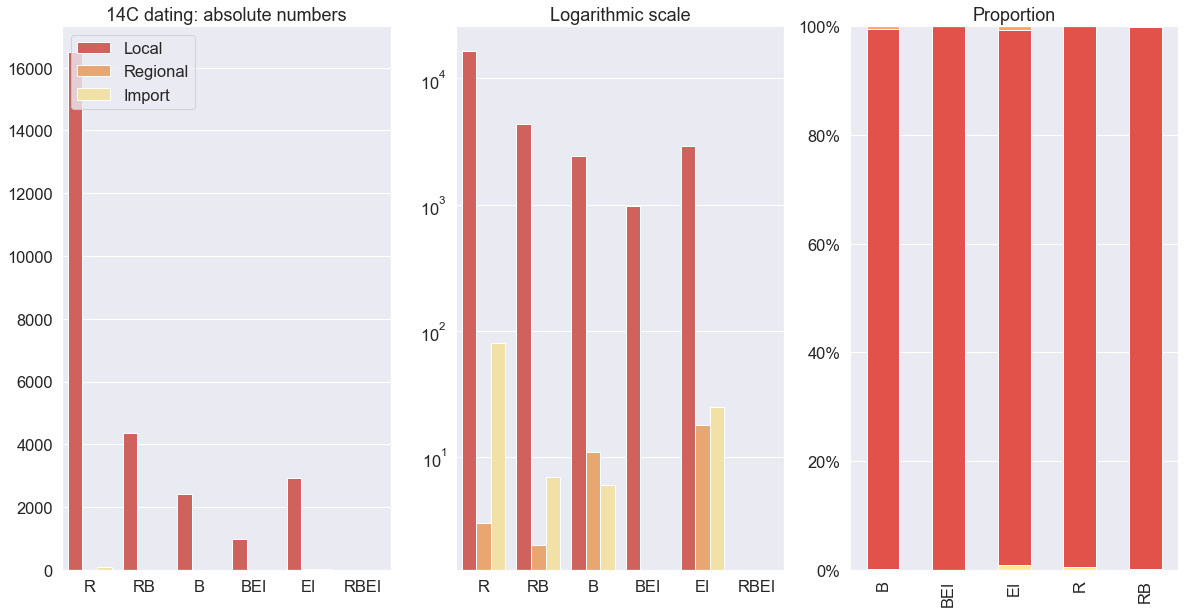

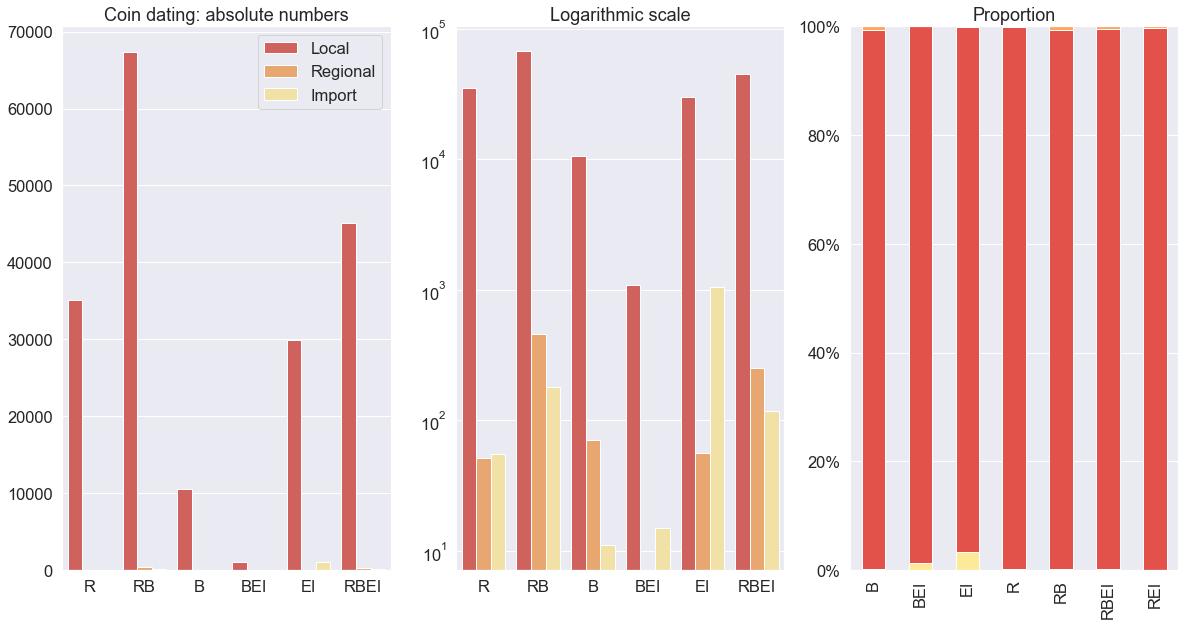

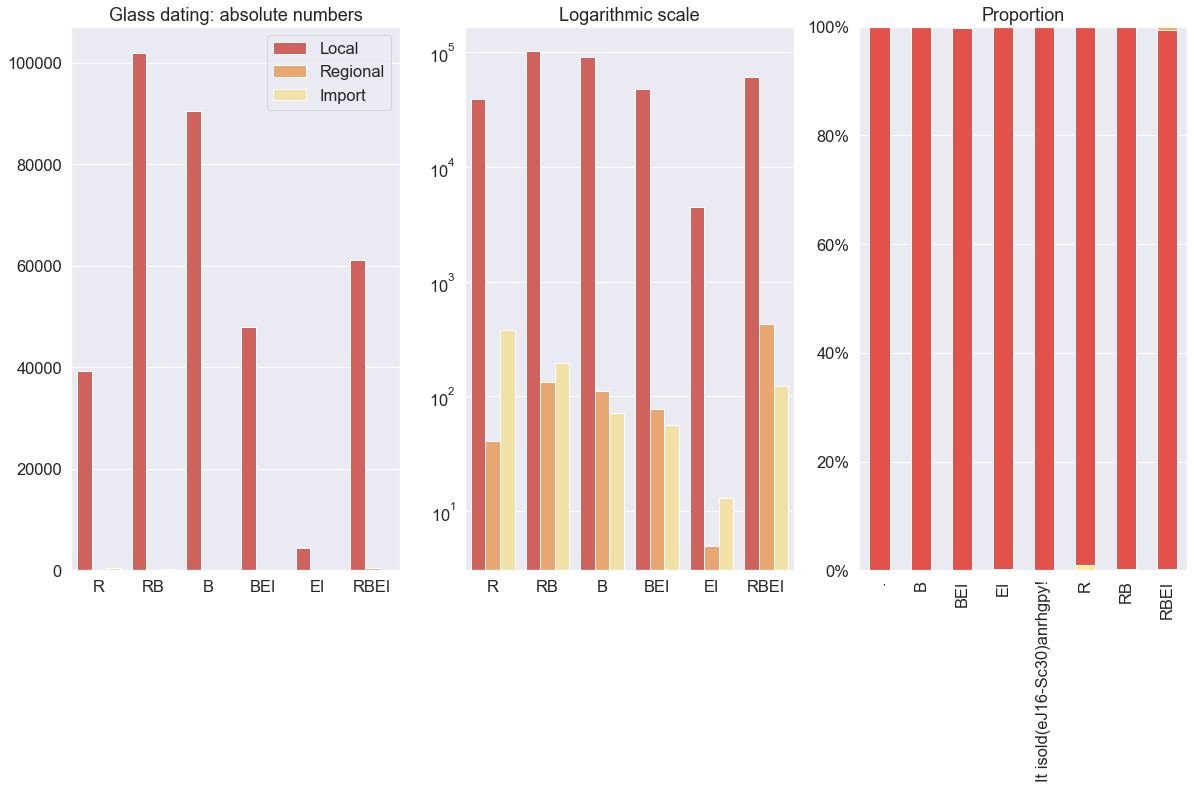

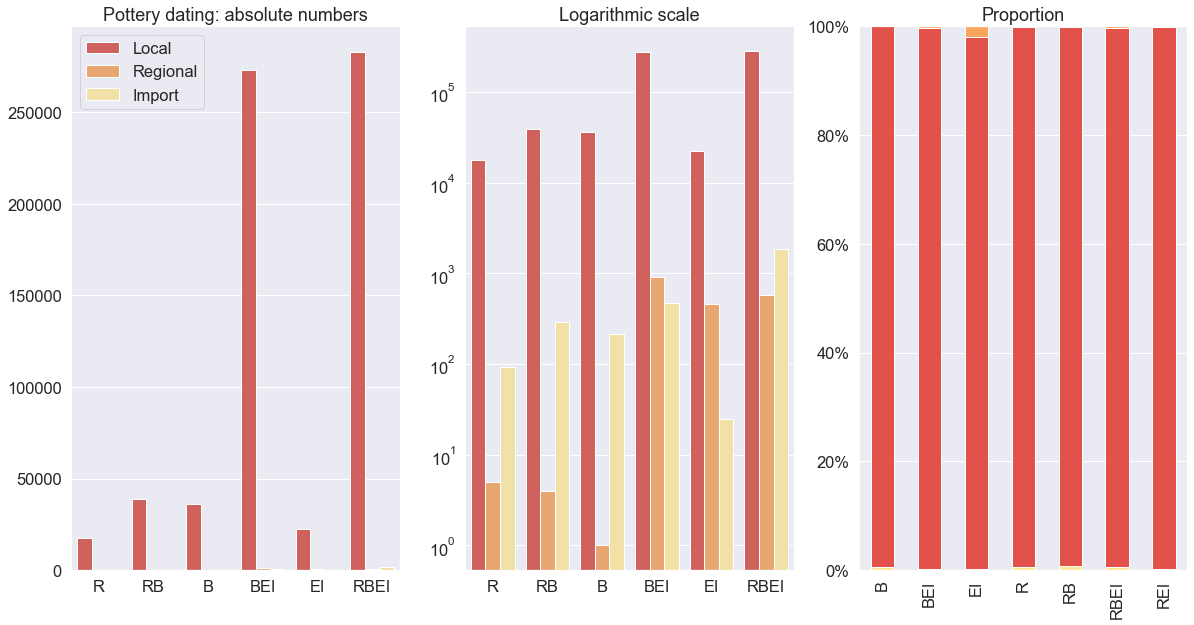

In [41]:
order = [ 'R', 'RB', 'B', 'BEI',  'EI']

ax1 = pic_maker('14C')
ax2 = pic_maker('Coin')
ax3 = pic_maker('Glass')
ax4 = pic_maker('Pottery')
#plt.savefig('chronoAll.png')

### Provenance per period using combined chronological evidence 

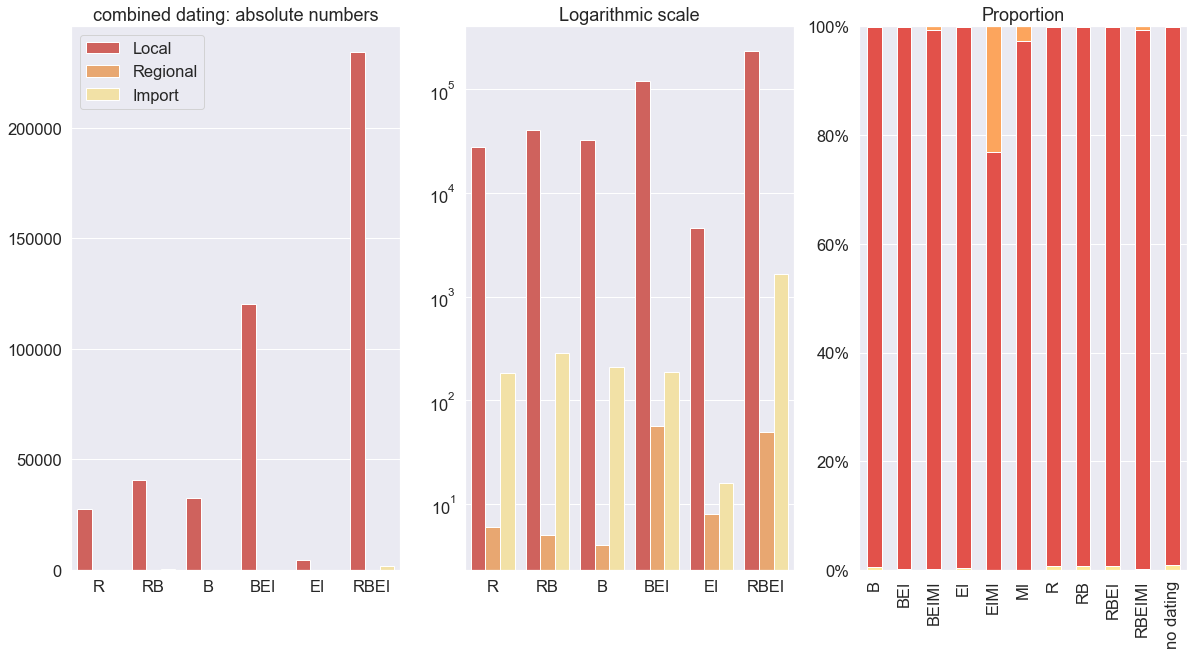

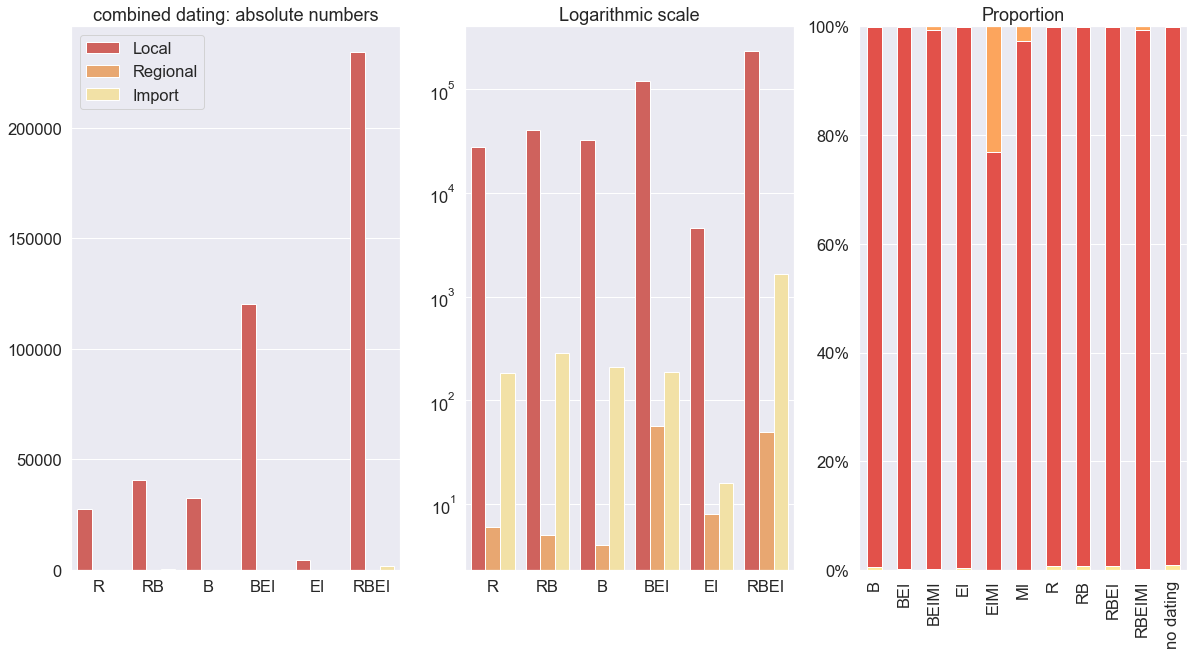

In [42]:
pic_maker('combined')
#plt.savefig('provenance.png', dpi = 300)

This is figure 17 in Romanowska et al. 2021. Trends in Ceramic Assemblages from the Northwest Quarter of Gerasa/Jerash, Jordan.

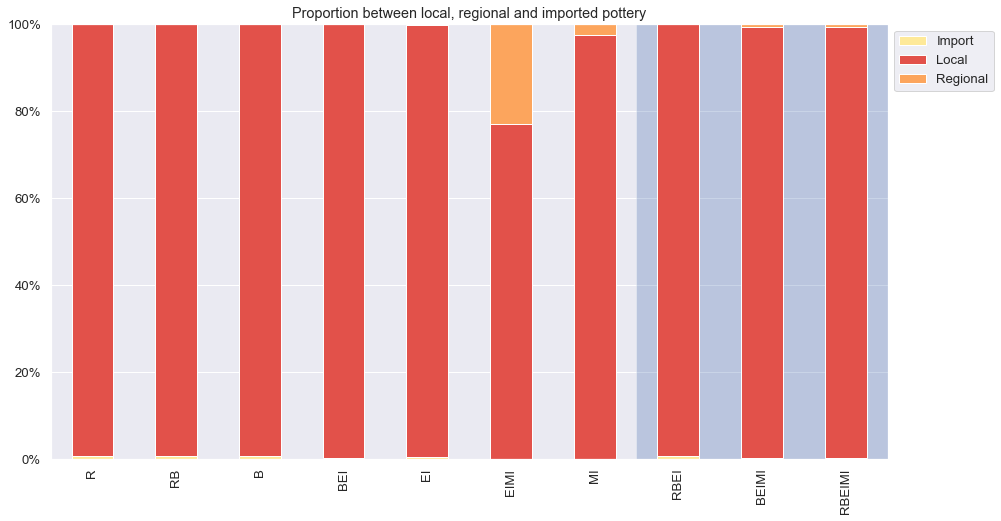

In [43]:
sns.set(font_scale = 1.2)
fig, ax = plt.subplots(figsize=(15,8))
plt.axvspan(xmin = 6.5, xmax = 10,  facecolor='b', alpha=0.3)
(df_f.set_index('combined').groupby(['combined','Local'])["AmountSum"]
                  .sum()                             # sum amounts per trench per evidence
                  .unstack()                         # crt the data frame
                  .T                                 # transpose
                  .apply(lambda x: x / x.sum())      # calculate frequencies per evidence
                  .T                                 # transpose back
                  .loc[all_order]
                  .plot(kind='bar',                  # plot
                      stacked=True, 
                      ax = ax,
                     figsize = (15,8), 
                        legend = False,
                       color = pal99, 
                       ylim = (0,1.0), 
                  title = "Proportion between local, regional and imported pottery"))

ax.set_yticklabels([str(x) +'%' for x in range(0,101,20)])
plt.xlabel("")
plt.legend(bbox_to_anchor=(1.0, 1), loc=2)

plt.savefig('figures/17.png', dpi = 600, bbox_inches = "tight")

### Distribution of pottery provenance per period + plain pottery removed
X-axis: number of artefacts; Y-axis: Chronology.

In [44]:
# remove just plain ware
df_NoPlain = df_f[~df_f.WareType.isin( ['Plain'])]
print('Total number origial: ', len(df_f),'AmountSum: ', df_f['AmountSum'].sum(),'Number without Plain Ware: ', len(df_NoPlain), 'AmountSum: ', df_NoPlain['AmountSum'].sum())


Total number origial:  5494 AmountSum:  715146 Number without Plain Ware:  4716 AmountSum:  249730


Text(0.5, 1.0, 'Dating by Pottery without Plain pottery')

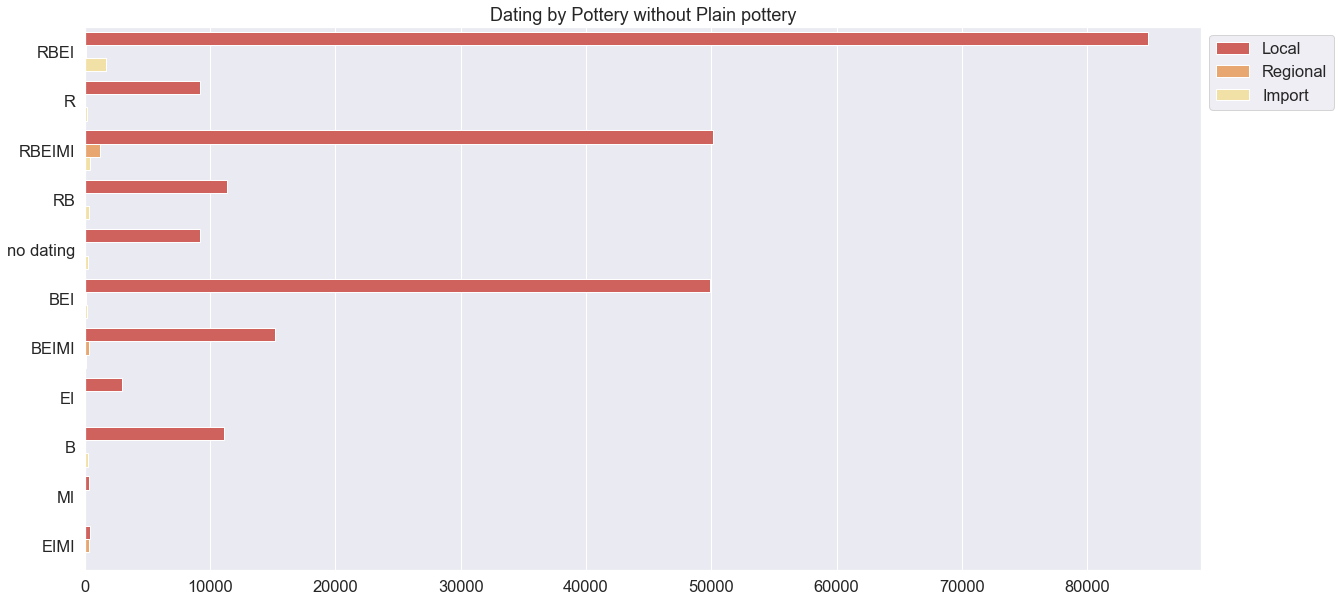

In [45]:
sns.set(palette = 'Spectral', font_scale = 1.5)
plt.figure(figsize = (20,10))
ax = sns.barplot(y = 'combined', 
                 x = 'AmountSum', 
                 hue = 'Local', 
                 data = df_NoPlain,
                 estimator= sum, 
                 ci = None)
ax.set(xlabel='', ylabel = '') 
plt.legend(bbox_to_anchor=(1.0, 1), loc=2)
plt.title('Dating by Pottery without Plain pottery')

# Provenance distribution per trench

X-axis: Trench; Y-axis: number of artefacts.

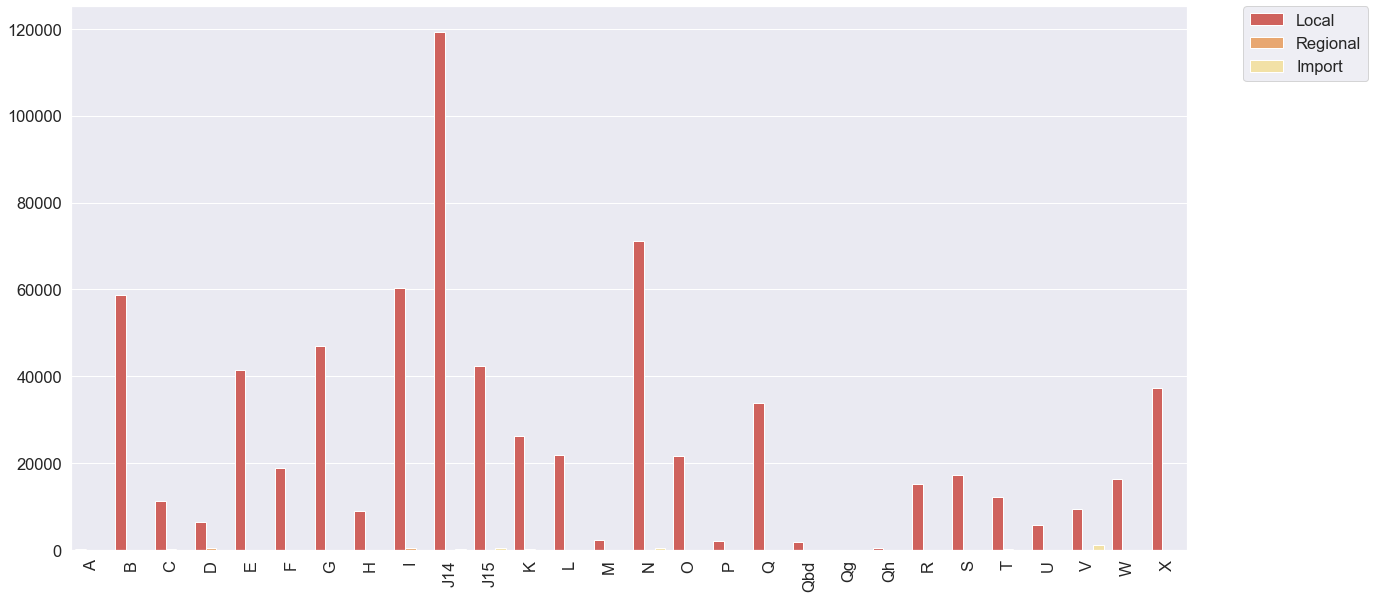

In [46]:
sns.set(palette = 'Spectral', font_scale = 1.5)
plt.figure(figsize = (20,10))

ax = sns.barplot(x = 'Trench', y = 'AmountSum', hue = 'Local', data = df_f, estimator= sum, ci = None)
plt.xticks(rotation = 90)
ax.set(xlabel='', ylabel = '') 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)

### Provenance - all trenches

X-axis: Trench; Y-axis: proportion of artefacts.

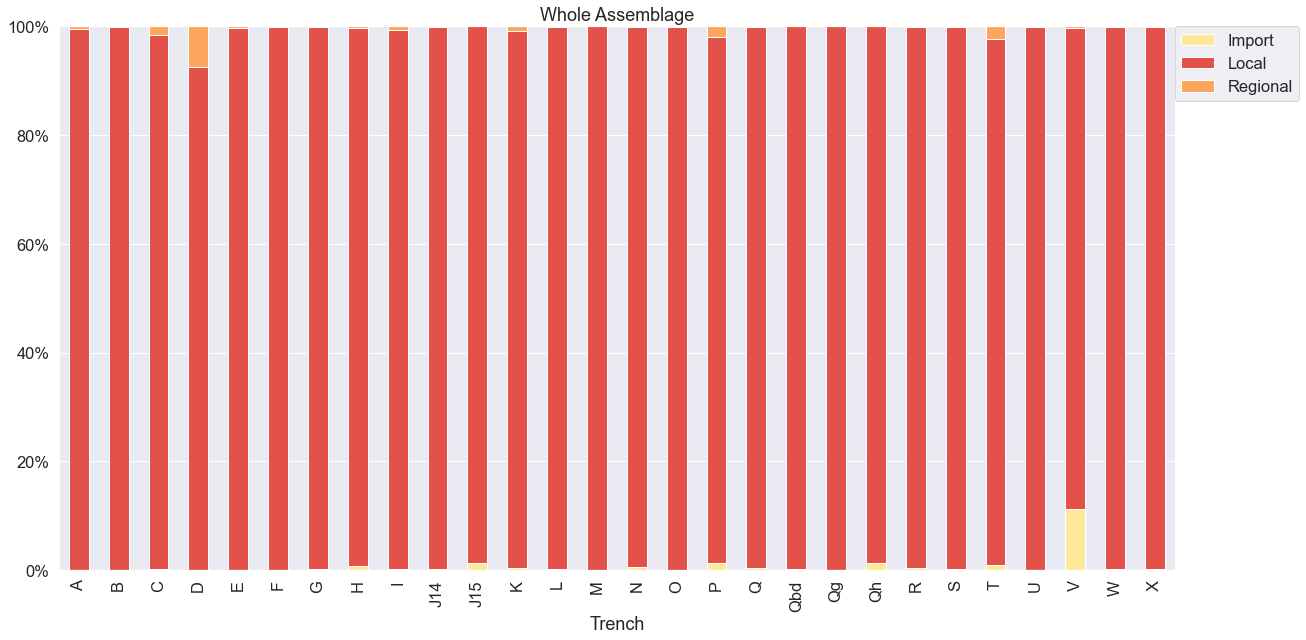

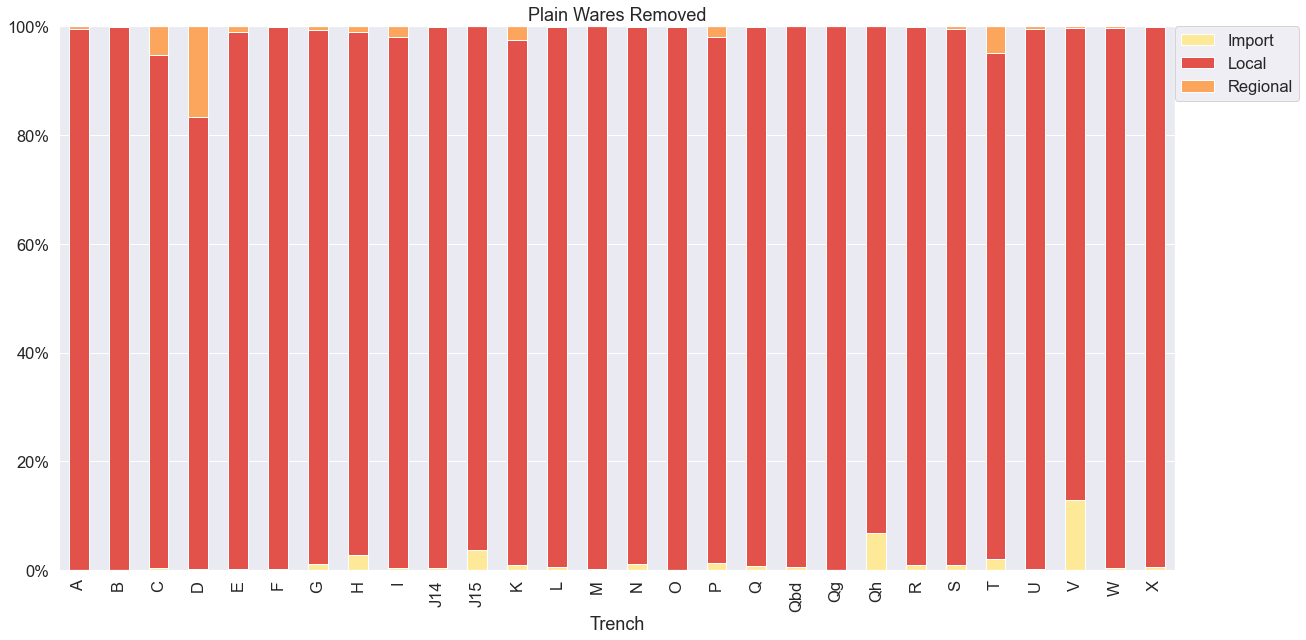

In [47]:
#sns.set(palette = pal1, font_scale = 1.5)
#sns.set_palette(pal1, 3)
# a bit of wiggle with the colours to make them consistent with previous plots
pal = sns.color_palette('Spectral')[:3]
a, b, c = pal
pal = c, a, b 
sns.set( font_scale = 1.5)
sns.set_palette(pal)

b = list('KPVBJN')
data_trenches1 = df_NoPlain [df_NoPlain['Trench'].isin(b)]
#fig, ax = plt.subplots(1,2)
df_f.name = 'Whole Assemblage'
df_NoPlain.name = 'Plain Wares Removed'
#df_NoPlain2.name = 'Three Selected Plain Wares Removed'
for i in ([df_f, df_NoPlain]):
    ax = (i.groupby(['Trench','Local'])["AmountSum"]
              .sum()                             # sum amounts per trench per evidence
              .unstack()                         # crt the data frame
              .T                                 # transpose
              .apply(lambda x: x / x.sum())      # calculate frequencies per evidence
              .T                                 # transpose back (there must be a better way...)
             # .loc[b]                            # order the bars 
              .plot(kind='bar',                  # plot
                  stacked=True, 
                  #colormap = pal1,
                  figsize = (20,10)))
    ax.set_yticklabels([str(x) +'%' for x in range(0,101,20)])

    plt.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0., ncol = 1)
    plt.ylim([0,1])
    plt.title(i.name)
    #plt.savefig('CiC_'+ str(i.name) + '.png', dpi = 600)


### Provenance distribution per trench in numbers

In [48]:
left = df_pot.groupby(['Trench','Local'])['AmountSum'].sum()
right = df_pot.groupby(['Trench'])['AmountSum'].sum()
trench_prov = pd.merge(left.to_frame(), right.to_frame(), left_index = True, right_index = True).reset_index() 
trench_prov = trench_prov.rename(columns = {'AmountSum_x':'Amount Sum','AmountSum_y': 'Total'})
trench_prov['Percentage'] = trench_prov['Amount Sum'] / trench_prov['Total'] * 100

cm = sns.light_palette("green", as_cmap=True)

s = trench_prov.style.background_gradient(cmap=cm)
display(s)

#you can also do it this way: 
#pivot_df = df_f.pivot_table( columns='Local', index = 'Trench', values='AmountSum', aggfunc = 'sum')
#pivot_df['sum'] = pivot_df.sum(axis = 1)
#pivot_df.apply(lambda x: 100 * x / pivot_df['sum'])

,Trench,Local,Amount Sum,Total,Percentage
0,A,Local,210,211,99.526066
1,A,Regional,1,211,0.473934
2,B,Import,13,58751,0.022127
3,B,Local,58724,58751,99.954043
4,B,Regional,14,58751,0.023829
5,C,Import,11,8232,0.133625
6,C,Local,8135,8232,98.821672
7,C,Regional,86,8232,1.044704
8,D,Import,4,5291,0.075600
9,D,Local,4848,5291,91.627292


### Selected trenches compared with the total

X-axis: Trench; Y-axis: proportion of artefacts.

This is figure 18 in Romanowska et al. 2021. Trends in Ceramic Assemblages from the Northwest Quarter of Gerasa/Jerash, Jordan.

In [49]:
df_pot.Trench.unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J14', 'J15', 'K',
       'L', 'M', 'N', 'O', 'P', 'Q', 'Qbd', 'Qg', 'Qh', 'R', 'S', 'T',
       'U', 'V', 'W', 'X'], dtype=object)

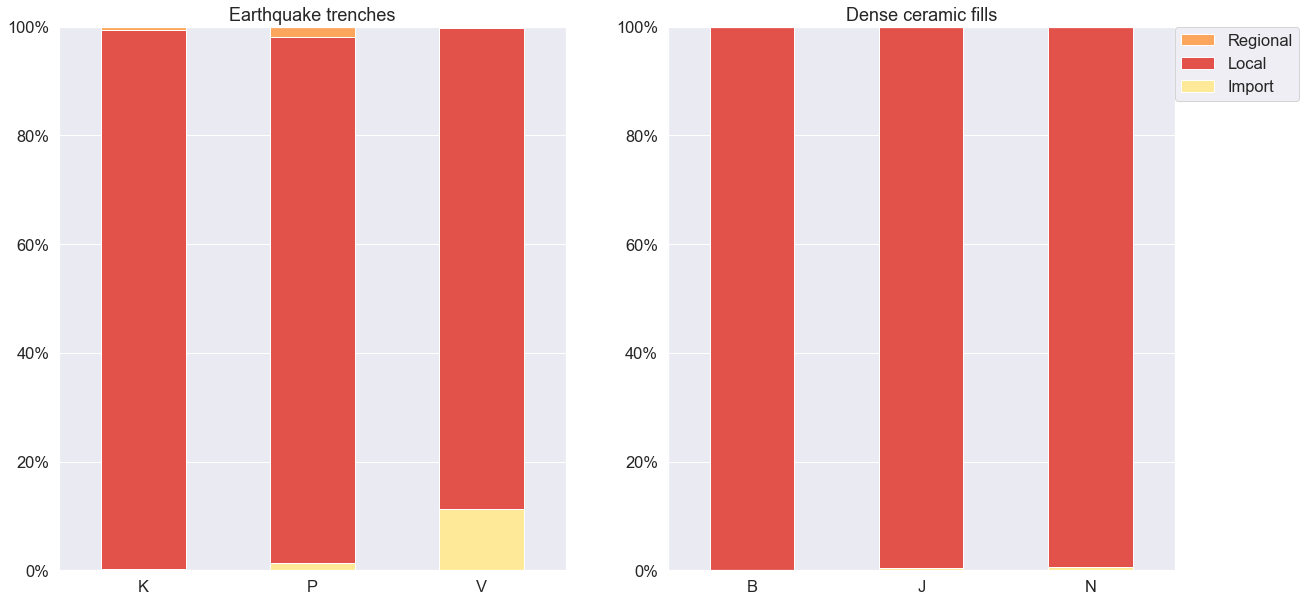

In [50]:
#plt.figure(figsize = (10, 20))


f, (ax1, ax2) = plt.subplots(1, 2,   figsize=(20,10))


# plot 1 - the earthquake trenches: K, P and V
b = list('KPV')
data_trenches1 = df_pot[df_pot['Trench'].isin(b)]
ax1 = (data_trenches1.groupby(['Trench','Local'])["AmountSum"]
              .sum()                             # sum amounts per trench per evidence
              .unstack()                         # crt the data frame
              .T                                 # transpose
              .apply(lambda x: x / x.sum())      # calculate frequencies per evidence
              .T                                 # transpose back
              .plot(kind='bar',                  # plot
                    stacked=True, 
                    ax = ax1,
                    legend = None,
                    title = 'Earthquake trenches'
                   ))
ax1.set_yticklabels([str(x) +'%' for x in range(0,101,20)])
ax1.set(xlabel='', ylabel = '') 
ax1.set_ylim([0,1])
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=360)

# plot 2 - the dense fill trenches: B, J and N
c = list('BJN')
# We will put the J trenches together because they are are of similar type of context (just excavated over 2 years)
combineJ = df_pot.copy()
combineJ.Trench = combineJ.Trench.replace({"J14":"J", "J15":"J"})
data_trenches2 = combineJ[combineJ['Trench'].isin(c)]


ax2 =(data_trenches2.groupby(['Trench','Local'])["AmountSum"]
              .sum()                             # sum amounts per trench per evidence
              .unstack()                         # crt the data frame
              .T                                 # transpose
              .apply(lambda x: x / x.sum())      # calculate frequencies per evidence
              .T                                 # transpose back
              .plot(kind='bar',                  # plot
                    stacked=True, 
                    ax = ax2, 
                    title = 'Dense ceramic fills'
                   ))
ax2.set_yticklabels([str(x) +'%' for x in range(0,101,20)])
ax2.set_ylim([0,1])
ax2.set(xlabel='', ylabel = '') 
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=360)

handles, labels = plt.gca().get_legend_handles_labels()
order2 = [2,1,0]
plt.legend([handles[idx] for idx in order2],[labels[idx] for idx in order2], bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0., ncol = 1)
plt.savefig('figures/18.png')

This is figure 2 in Romanowska et al. 2021. A study of the centuries-long reliance on local ceramics in Jerash through full quantification and simulation.

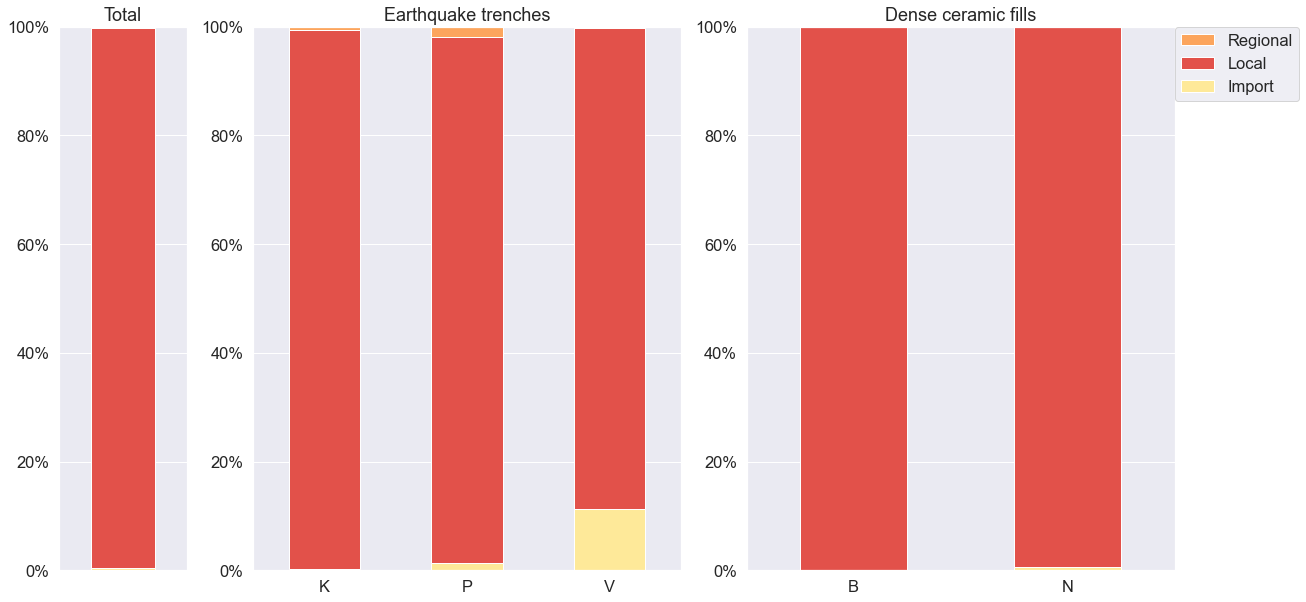

In [51]:
#plt.figure(figsize = (10, 20))


f, (ax0, ax1, ax2) = plt.subplots(1, 3,   figsize=(20,10), gridspec_kw = {'width_ratios':[0.6, 2, 2]})

# plot 1 - total proportion on the site
pivot_df = df_f.pivot_table( columns='Local', values='AmountSum', aggfunc = 'sum')
pivot_df = pivot_df.applymap(lambda x: x / df_f['AmountSum'].sum())
pivot_df.plot(kind='bar', stacked = True, ax = ax0, legend=False, title = 'Total')
ax0.set(xlabel='', ylabel = '') 
ax0.set_yticklabels([str(x) +'%' for x in range(0,101,20)])
ax0.set_ylim([0,1])
ax0.set_xticks([])

# plot 2 - the earthquake trenches: K, P and V
b = list('KPV')
data_trenches1 = df_pot[df_pot['Trench'].isin(b)]
ax1 = (data_trenches1.groupby(['Trench','Local'])["AmountSum"]
              .sum()                             # sum amounts per trench per evidence
              .unstack()                         # crt the data frame
              .T                                 # transpose
              .apply(lambda x: x / x.sum())      # calculate frequencies per evidence
              .T                                 # transpose back
              .plot(kind='bar',                  # plot
                    stacked=True, 
                    ax = ax1,
                    legend = None,
                    title = 'Earthquake trenches'
                   ))
ax1.set_yticklabels([str(x) +'%' for x in range(0,101,20)])
ax1.set(xlabel='', ylabel = '') 
ax1.set_ylim([0,1])
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=360)

# plot 3 - the dense fill trenches: B, J and N
c = list('BJN')

data_trenches1 = df_pot[df_pot['Trench'].isin(c)]

ax2 =(data_trenches1.groupby(['Trench','Local'])["AmountSum"]
              .sum()                             # sum amounts per trench per evidence
              .unstack()                         # crt the data frame
              .T                                 # transpose
              .apply(lambda x: x / x.sum())      # calculate frequencies per evidence
              .T                                 # transpose back
              .plot(kind='bar',                  # plot
                    stacked=True, 
                    ax = ax2, 
                    title = 'Dense ceramic fills'
                   ))
ax2.set_yticklabels([str(x) +'%' for x in range(0,101,20)])
ax2.set_ylim([0,1])
ax2.set(xlabel='', ylabel = '') 
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=360)

handles, labels = plt.gca().get_legend_handles_labels()
order2 = [2,1,0]
plt.legend([handles[idx] for idx in order2],[labels[idx] for idx in order2], bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0., ncol = 1)
#plt.savefig('Proportion_trenches_large.png')

In [52]:
data_trenchesV = df_pot[df_pot['Trench']== "V"]
data_v = data_trenchesV.groupby('Local')["AmountSum"].sum().reset_index()  
data_v["freq"] = data_v.AmountSum / data_v.AmountSum.sum() 
data_v


,Local,AmountSum,freq
0,Import,1199,0.112964
1,Local,9385,0.884210
2,Regional,30,0.002826


## Distribution of wares

X-axis: number of artefacts; Y-axis: Pottery types. 

This is figure 8 in Romanowska et al. 2021. Trends in Ceramic Assemblages from the Northwest Quarter of Gerasa/Jerash, Jordan.

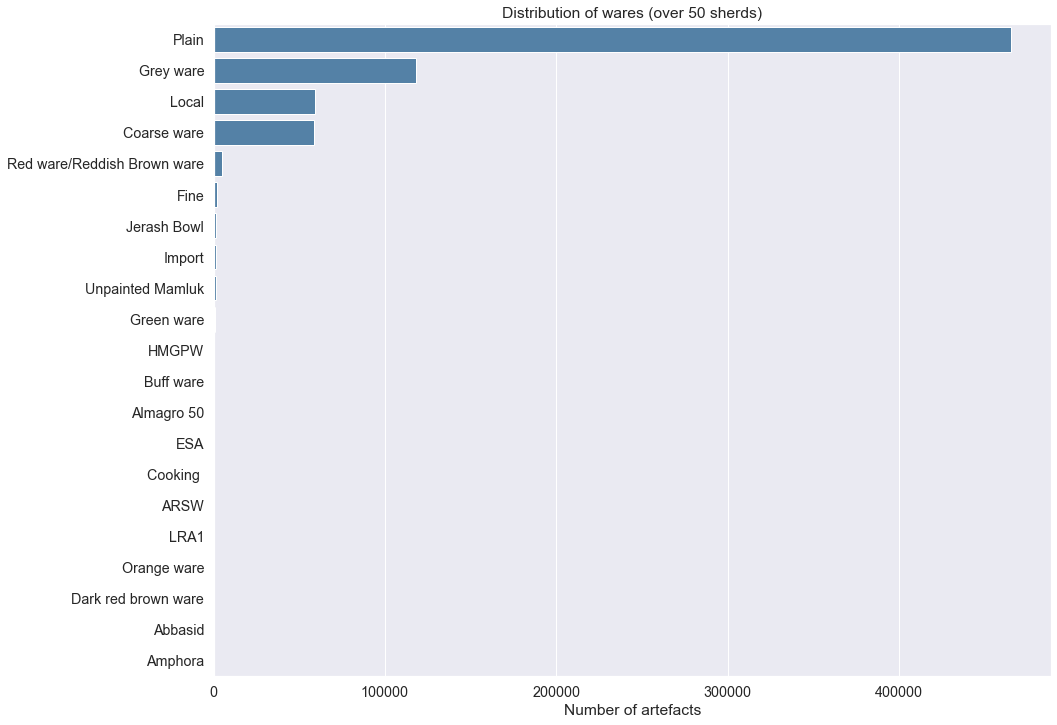

In [53]:
sns.set( font_scale = 1.3)
plt.figure(figsize = (15,12))
errors_wares= {'Grey Ware':'Grey ware','GreyWare':'Grey ware', 'Buff Ware':'Buff ware', 'Coarse Ware': 'Coarse ware', "Green Ware":"Green ware", "Late Roman ware":"LRRW", "ARS":"ARSW", "Roman sigillata":"Terra sigillata"}
df_f= df_f.replace(errors_wares)
order = df_f.groupby('WareType')["AmountSum"].sum().sort_values(ascending=False)
ax=sns.barplot(y = 'WareType', 
               x = 'AmountSum', 
               data = df_f, 
               order = order[order > 50].index,
               color = 'steelblue',
               estimator= sum, 
               ci = None)
ax.set(xlabel='Number of artefacts', ylabel = '') 
#plt.xticks(rotation= 45, horizontalalignment = "right")
plt.title('Distribution of wares (over 50 sherds)')
#ax.set_xscale('log')

plt.savefig('figures/8.png', dpi = 600, bbox_inches = "tight")

Without Plain ware

Text(0.5, 1.0, 'Distribution of wares without plain')

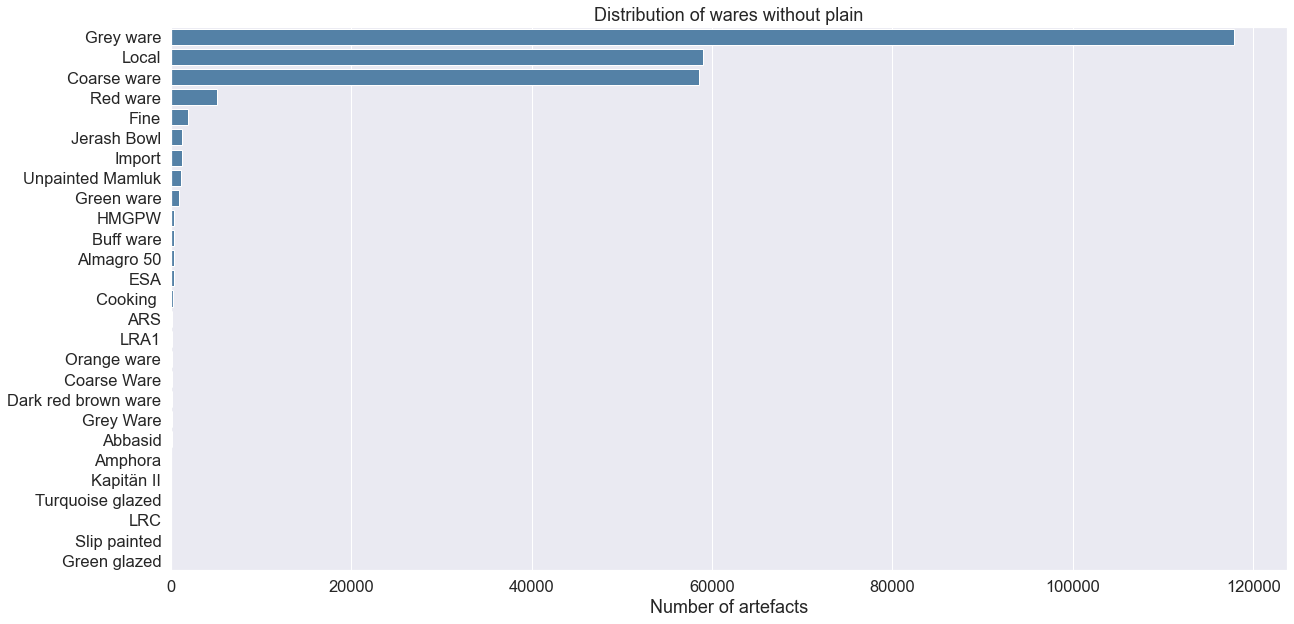

In [54]:
df_NoPlain = df_NoPlain.replace('Red ware/Reddish Brown ware', 'Red ware')
sns.set( font_scale = 1.5)
plt.figure(figsize = (20,10))
order = df_NoPlain.groupby('WareType')["AmountSum"].sum().sort_values(ascending=False)
ax=sns.barplot(y = 'WareType', 
               x = 'AmountSum', 
               data = df_NoPlain, 
               order = order[order > 10].index,
               color = 'steelblue',
               estimator= sum, 
               ci = None)
ax.set(xlabel='Number of artefacts', ylabel = '') 
plt.title('Distribution of wares without plain')


## Distribution of distinctive ware types

Plain, Grey, Coarse and Local wares were removed in the figure. Their numbers are so high it is difficult to see the distribution of the rest of the pottery assemblage (see the first Pottery types plot below). Their counts are included below in the table. Also, wares represented by less than 10 artefacts were removed. 

X-axis: number of artefacts; Y-axis: Ware types (note that the 4 most common wares have been removed).

This is figure 10 in Romanowska et al. 2021. Trends in Ceramic Assemblages from the Northwest Quarter of Gerasa/Jerash, Jordan.

In [55]:
# remove 5 common wares
df_NoPlain1 = df_f[~df_f.WareType.isin( ['Plain', 'Local', 'Grey ware', 'Coarse ware', 'Red ware/Reddish Brown ware'])]
df_f['WareType'] = df_f['WareType'].replace('Red ware/Reddish Brown ware', 'Red ware')
#df_NoPlain1 = df_NoPlain1.replace('Red ware/Reddish Brown ware', 'Red ware')

<Figure size 432x288 with 0 Axes>

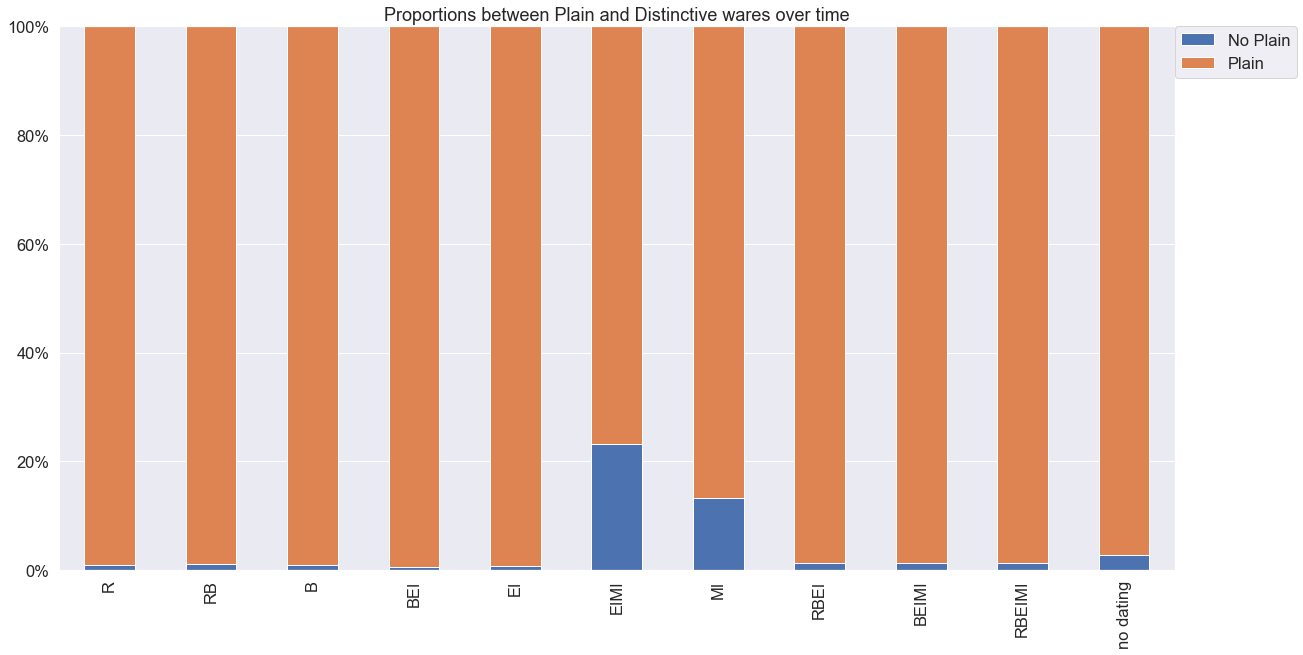

In [56]:
df_f["plainChange"] = ['Plain' if i in ['Plain', 'Local', 'Grey ware', 'Coarse ware','Red ware'] else 'No Plain' for i in df_f['WareType']]
plt.figure()
ax = (df_f.groupby(['combined','plainChange'])["AmountSum"]
              .sum()                             # sum amounts per trench per evidence
              .unstack()                         # crt the data frame
              .T                                 # transpose
              .apply(lambda x: x / x.sum())      # calculate frequencies per evidence
              .T                                 # transpose back (there must be a better way...)
              .reindex(all_order+['no dating'])
              .plot(kind='bar',                  # plot
                  stacked=True, 
                  figsize = (20,10)))
ax.set_yticklabels([str(x) +'%' for x in range(0,101,20)])
plt.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0., ncol = 1)
plt.ylim([0,1])
plt.title('Proportions between Plain and Distinctive wares over time')
ax.set(xlabel='')
#ax.set_xticklabels(['Unspecified pottery', 'Amphora', 'Storage and food preparation', 'Coarse ware', 'Cooking ware', 'Furnishing and specialised', 'Hand Made Geometric Painted', 'Tableware'])
#plt.title("")
plt.xticks(rotation = 90)
plt.savefig('figures/10.png', dpi = 600, bbox_inches = "tight")

In [57]:
(df_f.groupby(['combined','plainChange'])["AmountSum"]
              .sum()                             # sum amounts per trench per evidence
              .unstack()                         # crt the data frame
              .T                                 # transpose
              .apply(lambda x: x / x.sum())      # calculate frequencies per evidence
              .T                                 # transpose back (there must be a better way...)
              .reindex(all_order+['no dating']))

plainChange,No Plain,Plain
combined,,
R,0.009784,0.990216
RB,0.011049,0.988951
B,0.010049,0.989951
BEI,0.005090,0.994910
EI,0.007186,0.992814
EIMI,0.231984,0.768016
MI,0.131703,0.868297
RBEI,0.013682,0.986318
BEIMI,0.012787,0.987213


### Distribution of distinctive wares (five common wares removed)

This is figure 11 in Romanowska et al. 2021. Trends in Ceramic Assemblages from the Northwest Quarter of Gerasa/Jerash, Jordan.

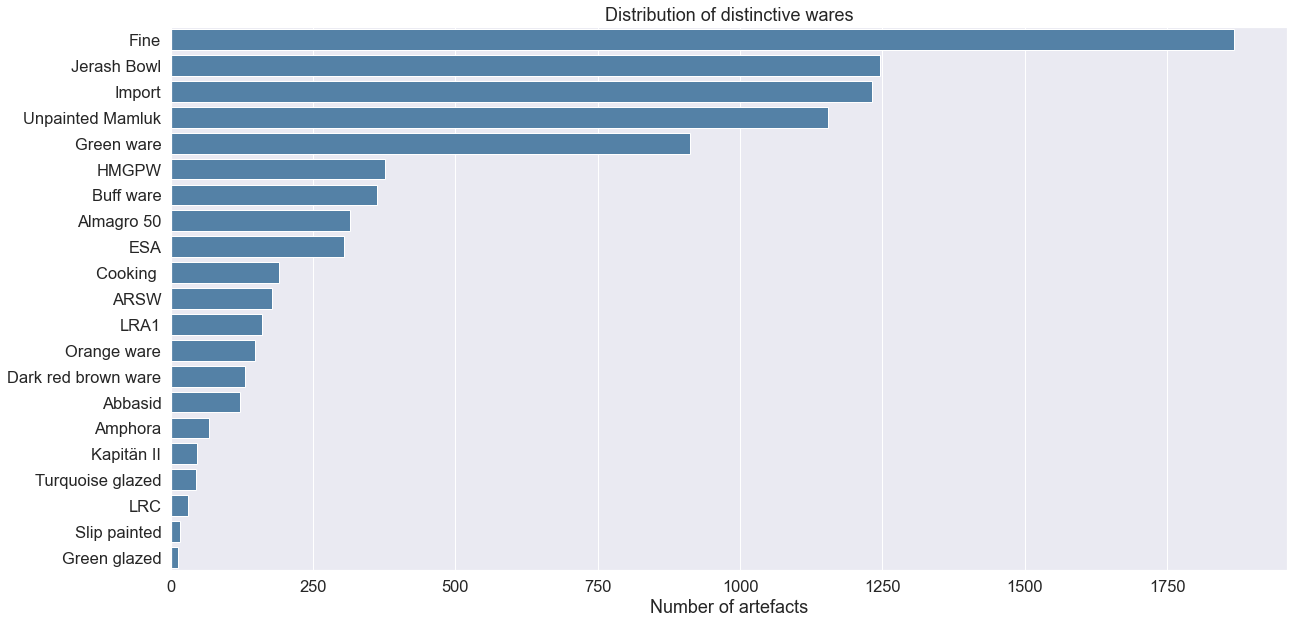

In [58]:
sns.set( font_scale = 1.5)
plt.figure(figsize = (20,10))
order = df_NoPlain1.groupby('WareType')["AmountSum"].sum().sort_values(ascending=False)
ax=sns.barplot(y = 'WareType', 
               x = 'AmountSum', 
               data = df_NoPlain1, 
               order = order[order > 10].index,
               color = 'steelblue',
               estimator= sum, 
               ci = None)
ax.set(xlabel='Number of artefacts', ylabel = '') 
plt.title('Distribution of distinctive wares')
plt.savefig("figures/11.png", dpi = 600, bbox_inches = "tight")

### Change over time of common and distinctive wares

This is figure 9 in Romanowska et al. 2021. Trends in Ceramic Assemblages from the Northwest Quarter of Gerasa/Jerash, Jordan.

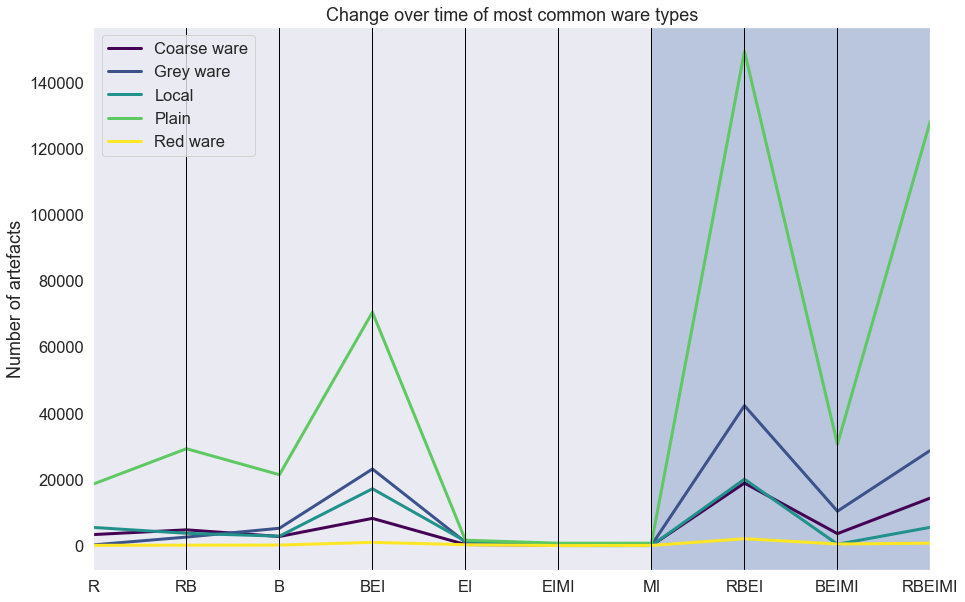

In [59]:
import pandas
from pandas.plotting import parallel_coordinates
sns.set( font_scale = 1.5)
sns.set_palette(sns.color_palette("Set2_r"))

flow_data = df_f[df_f.WareType.isin( ['Plain', 'Local', 'Grey ware', 'Coarse ware','Red ware'])].pivot_table(columns = ['WareType'], index = ["combined"],values = 'AmountSum', aggfunc = sum).T.reset_index()

flow_data = flow_data[['WareType', 'R', 'RB', 'B', 'BEI',  'EI', 'EIMI','MI', 'RBEI', 'BEIMI', 'RBEIMI']].fillna(0)

# Make the plot
fig = plt.figure(figsize=(15,10))
parallel_coordinates(flow_data, 'WareType', colormap = 'viridis', linewidth = 3)
#parallel_coordinates(flow_data, flow_data.index, colormap=plt.get_cmap("Set2"))

plt.axvspan(xmin = 6, xmax = 9,  facecolor='b', alpha=0.3)
plt.ylabel('Number of artefacts')
plt.title('Change over time of most common ware types')
plt.legend(bbox_to_anchor=(0.0, 1), loc=2)

plt.savefig('figures/9.png', dpi = 600, bbox_inches = "tight")
plt.show()

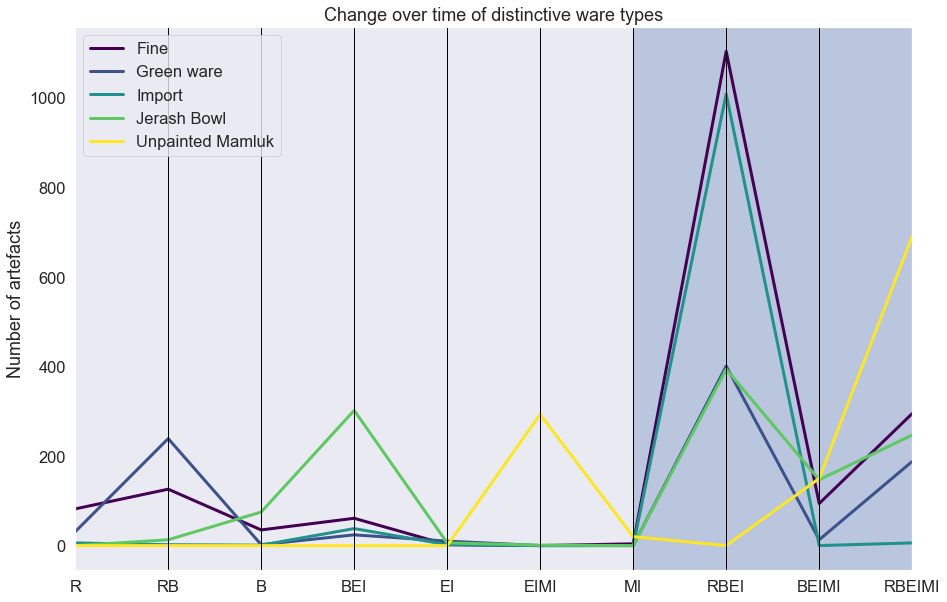

In [60]:

order = df_NoPlain1.groupby('WareType')["AmountSum"].sum().sort_values(ascending=False)
distinctive_data = df_NoPlain1[df_NoPlain1.WareType.isin(order[order > 500].index)]

flow_data = distinctive_data.pivot_table(columns = ['WareType'], index = ["combined"],values = 'AmountSum', aggfunc = sum).T.reset_index()
flow_data = flow_data[['WareType', 'R', 'RB', 'B', 'BEI',  'EI', 'EIMI','MI', 'RBEI', 'BEIMI', 'RBEIMI']].fillna(0)
# Make the plot
fig = plt.figure(figsize=(15,10))
parallel_coordinates(flow_data, 'WareType', colormap = 'viridis', linewidth = 3)
#parallel_coordinates(flow_data, flow_data.index, colormap=plt.get_cmap("Set2"))

plt.axvspan(xmin = 6, xmax = 9,  facecolor='b', alpha=0.3)
plt.ylabel('Number of artefacts')
plt.title('Change over time of distinctive ware types')
plt.legend(bbox_to_anchor=(0.0, 1), loc=2)

plt.savefig('figures/12.png', dpi = 600, bbox_inches = "tight")
plt.show()

In [61]:
"""# Alternative visualisations
coarse_data = df_f[df_f.WareType.isin( ['Plain', 'Local', 'Grey ware', 'Coarse ware'])]
# Make the plot
fig = plt.figure(figsize=(15,10))
sns.pointplot( x = 'combined', y = "AmountSum", hue = 'WareType', estimator = sum, data = coarse_data,order = ['R', 'RB', 'B', 'BEI',  'EI', 'REI','RBEI'] )
#plt.ylab
#parallel_coordinates(flow_data, flow_data.index, colormap=plt.get_cmap("Set2"))
plt.show()

########################
coarse_data = df_f[df_f.WareType.isin(order[order > 200].index)]
# Make the plot
fig = plt.figure(figsize=(15,10))
ax = sns.pointplot( x = 'combined', 
                   y = "AmountSum", 
                   hue = 'WareType', 
                   estimator = sum, 
                   data = coarse_data,
                   order = ['R', 'RB', 'B', 'BEI',  'EI'],
                  ci = None)
ax.set(xlabel='', ylabel = 'Number of artefacts')
plt.legend(bbox_to_anchor=(0.0, 1), loc=2)
plt.show()"""

'# Alternative visualisations\ncoarse_data = df_f[df_f.WareType.isin( [\'Plain\', \'Local\', \'Grey ware\', \'Coarse ware\'])]\n# Make the plot\nfig = plt.figure(figsize=(15,10))\nsns.pointplot( x = \'combined\', y = "AmountSum", hue = \'WareType\', estimator = sum, data = coarse_data,order = [\'R\', \'RB\', \'B\', \'BEI\',  \'EI\', \'REI\',\'RBEI\'] )\n#plt.ylab\n#parallel_coordinates(flow_data, flow_data.index, colormap=plt.get_cmap("Set2"))\nplt.show()\n\n########################\ncoarse_data = df_f[df_f.WareType.isin(order[order > 200].index)]\n# Make the plot\nfig = plt.figure(figsize=(15,10))\nax = sns.pointplot( x = \'combined\', \n                   y = "AmountSum", \n                   hue = \'WareType\', \n                   estimator = sum, \n                   data = coarse_data,\n                   order = [\'R\', \'RB\', \'B\', \'BEI\',  \'EI\'],\n                  ci = None)\nax.set(xlabel=\'\', ylabel = \'Number of artefacts\')\nplt.legend(bbox_to_anchor=(0.0, 1), loc=2

In [62]:
wares = df_f.groupby('WareType')['AmountSum'].sum().sort_values(ascending = False).reset_index()

wares['Percentage'] = wares['AmountSum'] / df_f.AmountSum.sum() * 100

cm = sns.light_palette("green", as_cmap=True)

s = wares.style.background_gradient(cmap=cm)
display(s)
wares.to_excel('wares.xlsx')

,WareType,AmountSum,Percentage
0,Plain,465416,65.079858
1,Grey ware,117950,16.493136
2,Local,59002,8.250343
3,Coarse ware,58730,8.212309
4,Red ware,5112,0.714819
5,Fine,1867,0.261066
6,Jerash Bowl,1245,0.174090
7,Import,1232,0.172273
8,Unpainted Mamluk,1154,0.161366
9,Green ware,912,0.127526


In [63]:
# Percentage of four most common wares together
wares.iloc[:4,2].sum()

98.03564586811645

## Pottery types

[Text(0, 0.5, ''), Text(0.5, 0, '')]

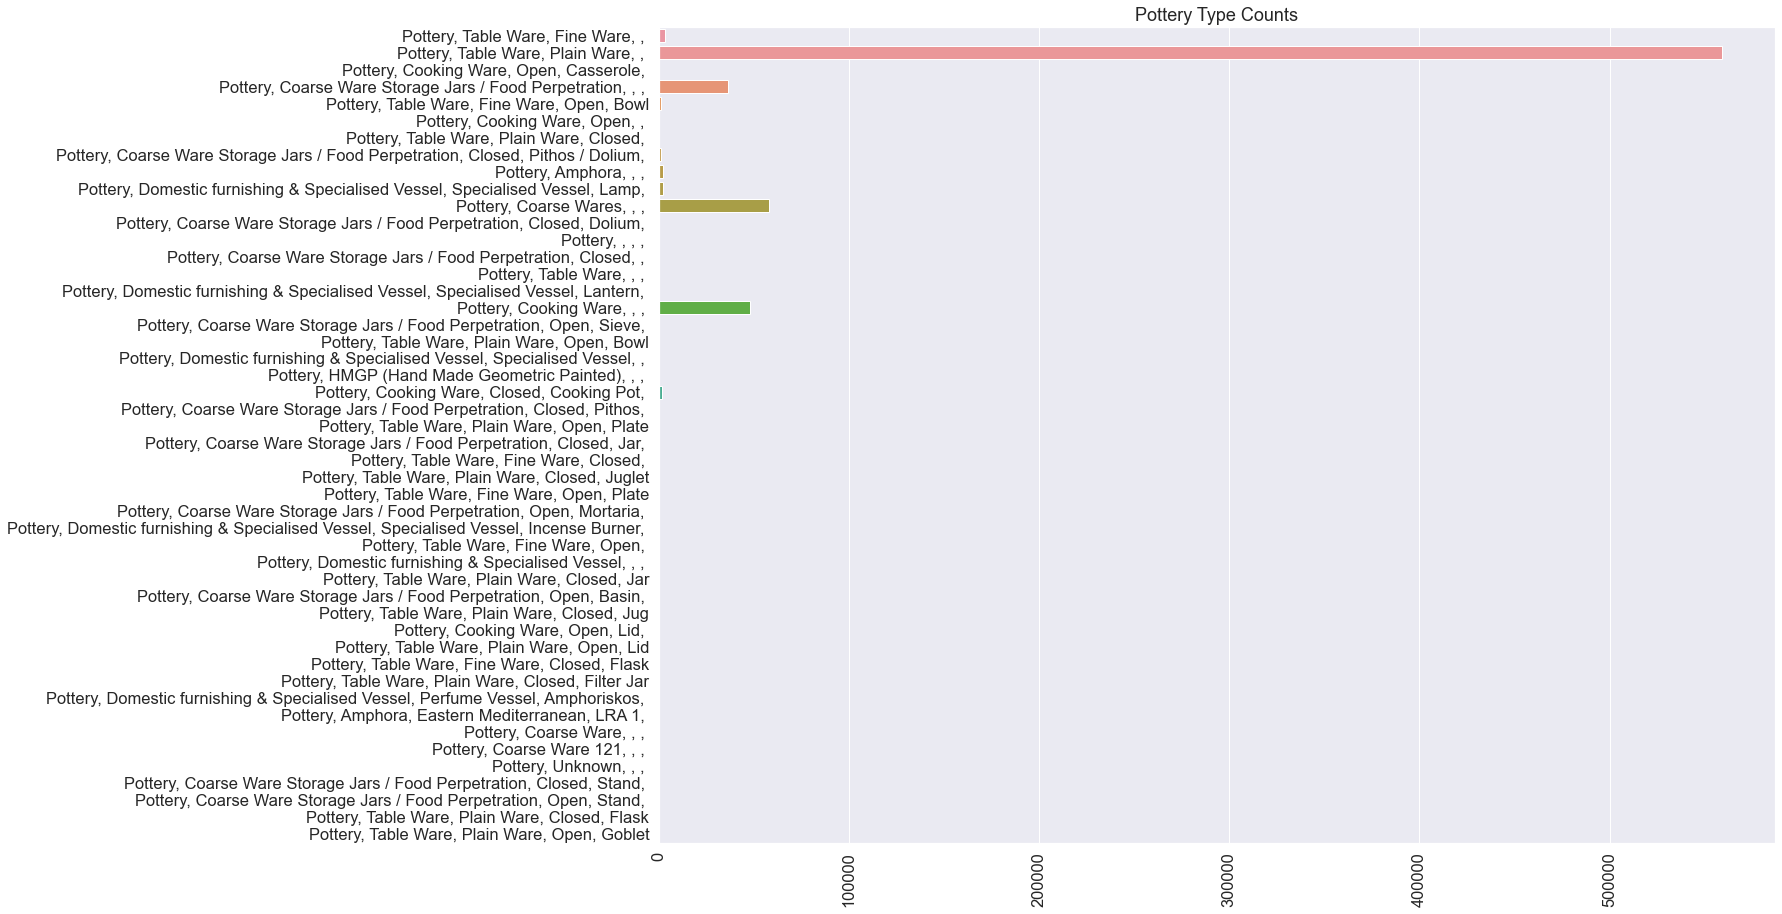

In [64]:
plt.figure(figsize = (20,15))

ax = sns.barplot(y = 'Type_verbose', x = 'AmountSum', data = df_f, estimator= sum, ci = None)
plt.xticks(rotation = 90)
plt.title('Pottery Type Counts')
ax.set(xlabel='', ylabel = '') 

In [65]:
pot_types = df_f.groupby('Type_verbose')['AmountSum'].sum().sort_values(ascending = False).reset_index()

pot_types['Percentage'] = pot_types['AmountSum'] / df_f.AmountSum.sum() * 100

cm = sns.light_palette("green", as_cmap=True)

s = pot_types.style.background_gradient(cmap=cm)
display(s)
pot_types.to_excel('pot_types.xlsx')
print(pot_types.iloc[:4,2].sum())

,Type_verbose,AmountSum,Percentage
0,"Pottery, Table Ware, Plain Ware, ,",558997,78.165438
1,"Pottery, Coarse Wares, , ,",57958,8.104359
2,"Pottery, Cooking Ware, , ,",48112,6.727577
3,"Pottery, Coarse Ware Storage Jars / Food Perpetration, , ,",36208,5.063022
4,"Pottery, Table Ware, Fine Ware, ,",3459,0.483677
5,"Pottery, Domestic furnishing & Specialised Vessel, Specialised Vessel, Lamp,",2158,0.301757
6,"Pottery, Amphora, , ,",2094,0.292807
7,"Pottery, Cooking Ware, Closed, Cooking Pot,",1890,0.264282
8,"Pottery, Coarse Ware Storage Jars / Food Perpetration, Closed, Pithos / Dolium,",1245,0.174090
9,"Pottery, Table Ware, Fine Ware, Open, Bowl",1159,0.162065


98.06039605898656


### Distribution of Pottery Types without the common pottery types
Here the plain pottery is eliminated by removing specific types of ceramics,e.g., 'Coarse Ware', 'Table Ware, Plain', 'Cooking Ware', etc.

In [66]:
df_NoPlain2 = df_f[~df_f.Type.isin( ['25500', '26000','2121000', '27000'])]
print('Total number original: ', len(df_f), 
      'AmountSum: ', df_f['AmountSum'].sum(), 
      'Number without the Plain types: ', len(df_NoPlain2), 
      'AmountSum: ', df_NoPlain2['AmountSum'].sum())


Total number original:  5494 AmountSum:  715146 Number without the Plain types:  1920 AmountSum:  13729


[Text(0, 0.5, ''), Text(0.5, 0, '')]

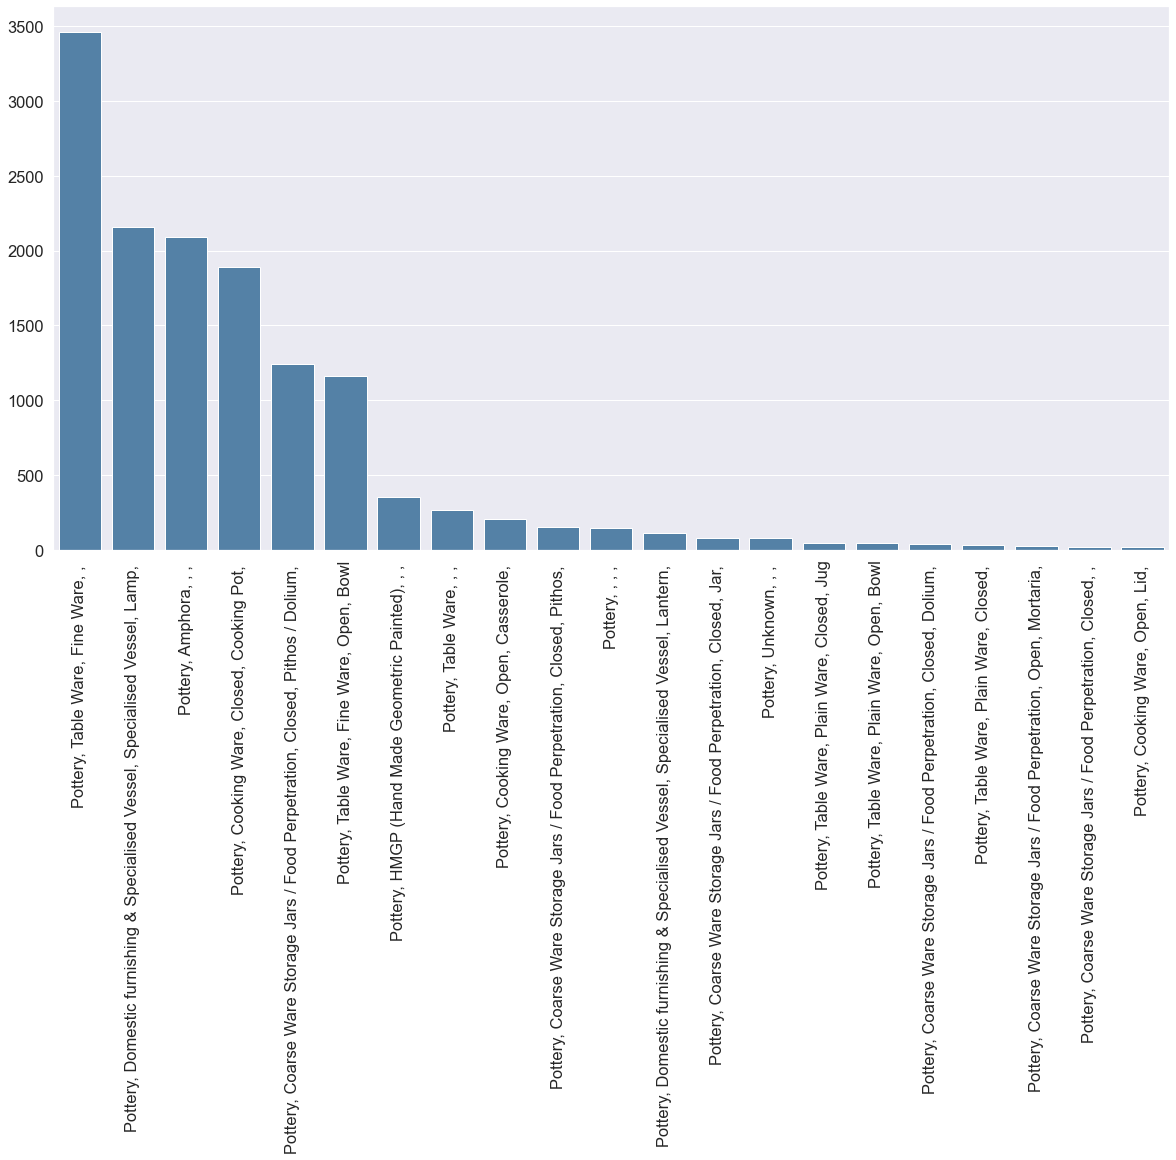

In [67]:
order = df_NoPlain2.groupby(['Type_verbose'])['AmountSum'].sum().sort_values(ascending=False)

plt.figure(figsize = (20,10))

ax = sns.barplot(x = 'Type_verbose', 
                 y = 'AmountSum', 
                 data = df_NoPlain2, 
                 estimator= sum, 
                 color = 'steelblue',
                 order = order[order > 20].index, 
                 ci = None)
plt.xticks(rotation = 90)
#plt.title('Pottery types counts without the Plain Tableware')
ax.set(xlabel='', ylabel = '') 

### Divide by the high level division (S1, S2)
Also print all instances of 'unknown' for excavators to check. 

In [68]:
df_f.groupby('Type_verbose')['AmountSum'].sum()

Type_verbose
Pottery, , , ,                                                                                146
Pottery, Amphora, , ,                                                                        2094
Pottery, Amphora, Eastern Mediterranean, LRA 1,                                                 4
Pottery, Coarse Ware 121, , ,                                                                  11
Pottery, Coarse Ware Storage Jars / Food Perpetration, , ,                                  36208
Pottery, Coarse Ware Storage Jars / Food Perpetration, Closed, ,                               22
Pottery, Coarse Ware Storage Jars / Food Perpetration, Closed, Dolium,                         37
Pottery, Coarse Ware Storage Jars / Food Perpetration, Closed, Jar,                            83
Pottery, Coarse Ware Storage Jars / Food Perpetration, Closed, Pithos / Dolium,              1245
Pottery, Coarse Ware Storage Jars / Food Perpetration, Closed, Pithos,                        155
Pottery

In [69]:
#df_f[['Type_high','Type_high_verbose' ]][30:100]
#print(df_f[['Type_high', 'Type_high_verbose']].drop_duplicates())
#df_test = df_f[['Type', 'Type_verbose']].drop_duplicates()
#print(len(df_test['Type_verbose'].unique()))
#print(len(df_test['Type_verbose']))
#print(df_test.Type[df_test.Type.duplicated(keep=False)])
#print(df_test)
#df_f.loc[3707]

# there were a number of typos in the data, here we correct these entries (note that the data file remains unchanged, this is done of the copy of the data)
corr_dict = {'Pottery, Cooking Ware, , , ':'26000'}
corr_dict2 = {'2121000':'Pottery, Coarse Wares, , , '}
df_f['Type'] = df_f['Type_verbose'].map(corr_dict).fillna(df_f['Type'])
df_f['Type_verbose'] = df_f['Type'].map(corr_dict2).fillna(df_f['Type_verbose'])

df_f['Type'].iloc[3706] = '2121000'
df_f['Type_verbose'].iloc[3706] = 'Pottery, Coarse Wares, , , '
#df_f.iloc[3692]

df_f['Type_high'] = df_f['Type'].astype(str).str[:2]
#print(df_f.Type.unique())
temp_dic = {'Pottery Unknown': 'Pottery ', "Pottery Coarse Ware 121":"Pottery Coarse Ware", "Pottery Coarse Wares":"Pottery Coarse Ware"}

df_f['Type_high_verbose'] = df_f['Type_verbose'].apply(lambda x: ''.join(x.split(',')[:2]))
#print(df_f['Type_high_verbose'].unique())

df_f['Type_high_verbose_simplified'] = df_f['Type_high_verbose'].map(temp_dic).fillna(df_f['Type_high_verbose'])
# Print all instances of 'Pottery Unknown' for the excavators to check
df_f[df_f['Type_verbose'].str.contains("Unknown")]


C:\Users\au680564\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Trench,Evidence,AmountSum,Type,Type_verbose,Local,WareType,14C,Coin,Glass,Pottery,Comments,MI,combined,plainChange,Type_high,Type_high_verbose,Type_high_verbose_simplified
4888,U,41,3,28000,"Pottery, Unknown, , ,",Local,Coarse ware,NaN,R,NaN,BEI,NaN,NaN,RBEI,Plain,28,Pottery Unknown,Pottery
4948,U,80,2,28000,"Pottery, Unknown, , ,",Local,Coarse ware,BEI,NaN,NaN,NaN,"1σ 614–679 AD (614–679 AD, 68.2%), 2σ 582–766 ...",NaN,BEI,Plain,28,Pottery Unknown,Pottery
4953,U,80,9,28000,"Pottery, Unknown, , ,",Local,Plain,BEI,NaN,NaN,NaN,"1σ 614–679 AD (614–679 AD, 68.2%), 2σ 582–766 ...",NaN,BEI,Plain,28,Pottery Unknown,Pottery
5207,W,20,1,28000,"Pottery, Unknown, , ,",Import,Import,NaN,NaN,NaN,BEI,NaN,NaN,BEI,No Plain,28,Pottery Unknown,Pottery
5317,W,5,3,28000,"Pottery, Unknown, , ,",Local,Coarse ware,NaN,NaN,NaN,RB,NaN,NaN,RB,Plain,28,Pottery Unknown,Pottery
5321,W,5,23,28000,"Pottery, Unknown, , ,",Local,Plain,NaN,NaN,NaN,RB,NaN,NaN,RB,Plain,28,Pottery Unknown,Pottery
5465,X,4,9,28000,"Pottery, Unknown, , ,",Local,Coarse ware,NaN,RB,NaN,RBEI,NaN,NaN,RBEI,Plain,28,Pottery Unknown,Pottery
5475,X,4,32,28000,"Pottery, Unknown, , ,",Local,Plain,NaN,RB,NaN,RBEI,NaN,NaN,RBEI,Plain,28,Pottery Unknown,Pottery


### Distribution of pottery functional types

X-axis: Pottery types (High level division) ; Y-axis: number of artefacts. 

This is figure 13 in Romanowska et al. 2021. Trends in Ceramic Assemblages from the Northwest Quarter of Gerasa/Jerash, Jordan.

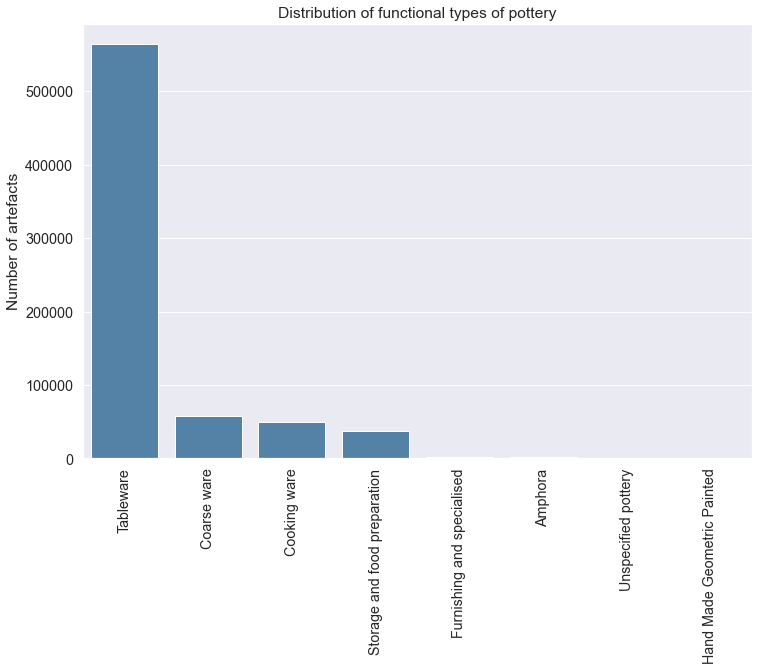

In [70]:
sns.set( font_scale = 1.3)

sns.set_palette("Spectral", 8)
fig = plt.figure(figsize =(12, 8))
ax = sns.barplot(x = 'Type_high_verbose_simplified' , 
                 y = 'AmountSum', 
                 estimator = sum, 
                 order = df_f.groupby('Type_high_verbose_simplified')['AmountSum'].sum().sort_values(ascending=False).index,
                 data = df_f, 
                 color = 'steelblue',
                 ci = None)
ax.set(xlabel='', ylabel = 'Number of artefacts') 
# we manually assign labels because the ones in the data are a bit long, comment out the line below to see
ax.set_xticklabels(['Tableware', 'Coarse ware', 'Cooking ware', 'Storage and food preparation',  'Furnishing and specialised', 'Amphora','Unspecified pottery', 'Hand Made Geometric Painted'])
plt.xticks(rotation = 90)
plt.title('Distribution of functional types of pottery')
#ax.set_yscale('log')
plt.savefig('figures/13.png', dpi = 600, bbox_inches = "tight")

In [71]:
print(df_f.groupby("Type_high_verbose_simplified")['AmountSum'].sum().sort_values(ascending=False))
#df_f.groupby(["Type_high_verbose_simplified"])['AmountSum'].sum().sort_values(ascending=False).plot(kind='bar')

Type_high_verbose_simplified
Pottery Table Ware                                      564048
Pottery Coarse Ware                                      58111
Pottery Cooking Ware                                     50233
Pottery Coarse Ware Storage Jars / Food Perpetration     37793
Pottery Domestic furnishing & Specialised Vessel          2282
Pottery Amphora                                           2098
Pottery HMGP (Hand Made Geometric Painted)                 353
Pottery                                                    228
Name: AmountSum, dtype: int64


In [72]:
pot_types = df_f.groupby('Type_high_verbose_simplified')['AmountSum'].sum().sort_values(ascending = False).reset_index()

pot_types['Percentage'] = pot_types['AmountSum'] / df_f.AmountSum.sum() * 100

cm = sns.light_palette("green", as_cmap=True)

s = pot_types.style.background_gradient(cmap=cm)
display(s)
pot_types.to_excel('pot_types_hig.xlsx')

,Type_high_verbose_simplified,AmountSum,Percentage
0,Pottery Table Ware,564048,78.871727
1,Pottery Coarse Ware,58111,8.125753
2,Pottery Cooking Ware,50233,7.024160
3,Pottery Coarse Ware Storage Jars / Food Perpetration,37793,5.284655
4,Pottery Domestic furnishing & Specialised Vessel,2282,0.319096
5,Pottery Amphora,2098,0.293367
6,Pottery HMGP (Hand Made Geometric Painted),353,0.049361
7,Pottery,228,0.031882


### Distribution of non-plain tableware 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text major ticklabel objects>)

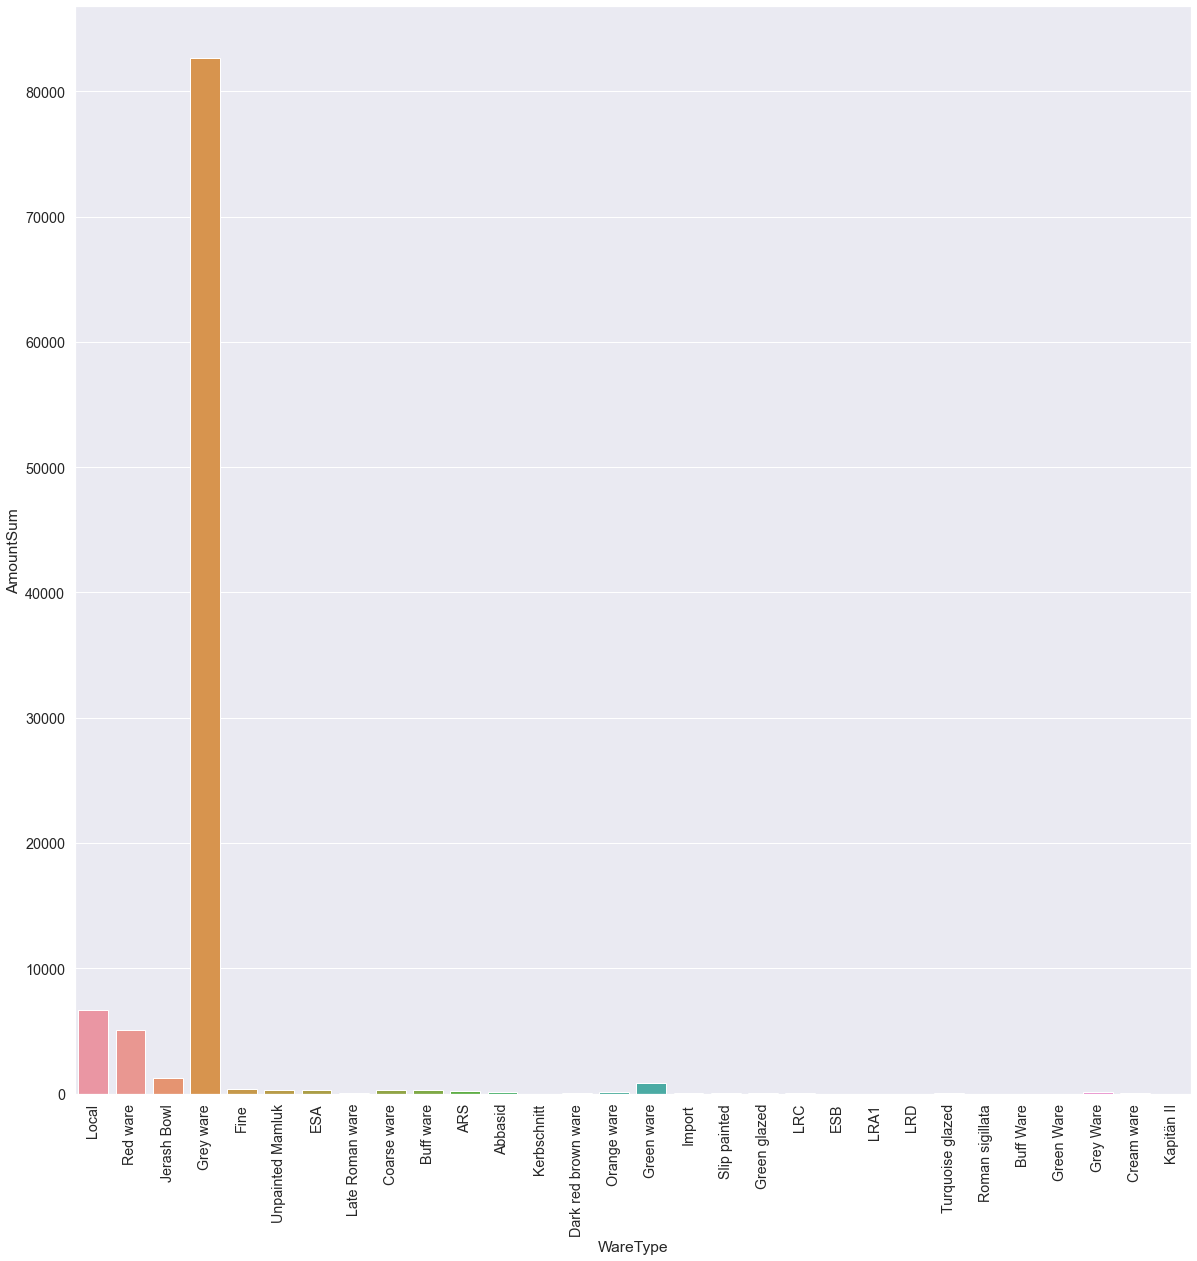

In [73]:
plt.figure(figsize = (20,20))
tableWare = df_NoPlain[df_NoPlain['Type_verbose'].str.contains('Pottery, Table Ware')]
sns.barplot(x = 'WareType', y = 'AmountSum', estimator = sum, data = tableWare, ci = None)
plt.xticks(rotation = 90)

### Distribution of non-plain coarse ware 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

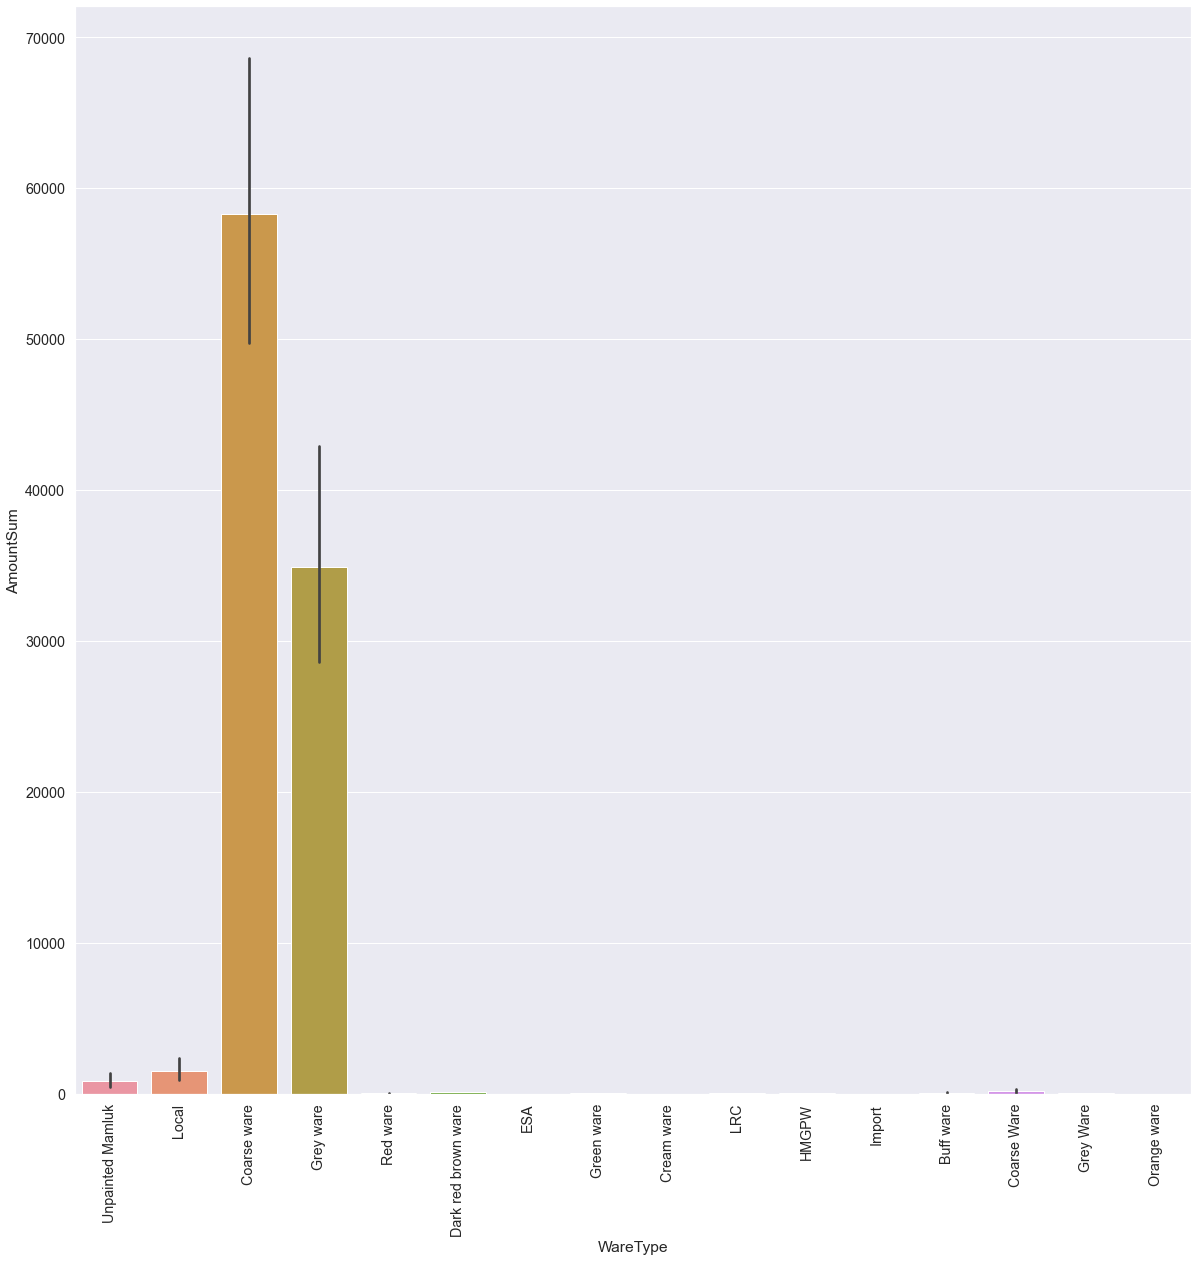

In [74]:
plt.figure(figsize = (20,20))
tableWare = df_NoPlain[df_NoPlain['Type_verbose'].str.contains('Coarse Ware')]
sns.barplot(x = 'WareType', y = 'AmountSum', estimator = sum, data = tableWare)
plt.xticks(rotation = 90)

### Distribution of non-plain cooking ware 

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

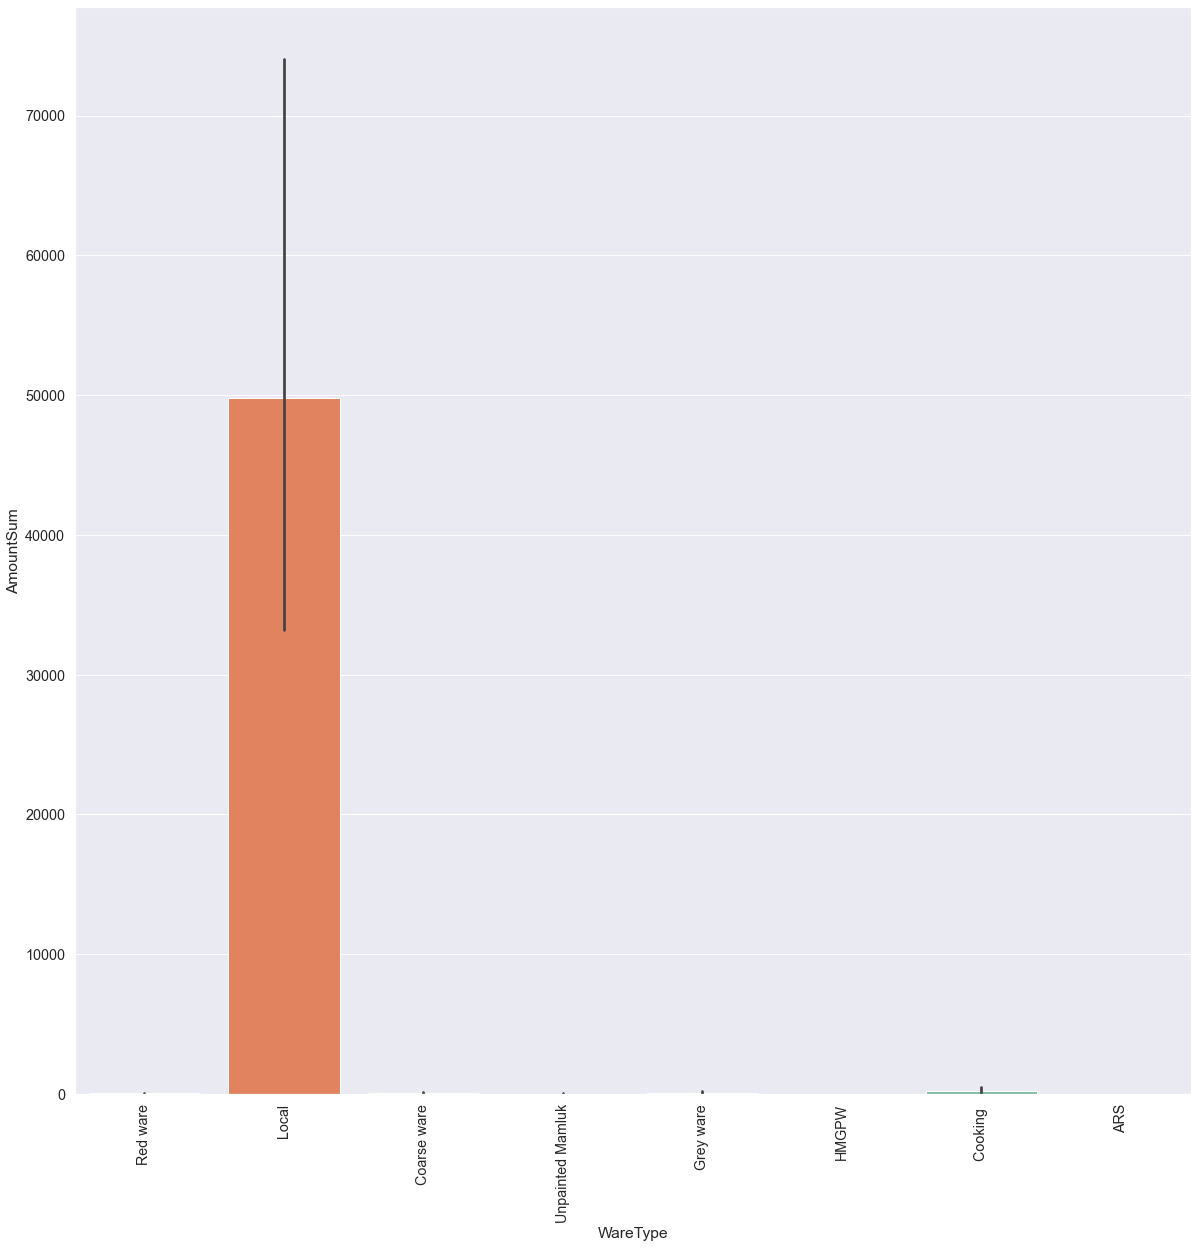

In [75]:
plt.figure(figsize = (20,20))
tableWare = df_NoPlain[df_NoPlain['Type_verbose'].str.contains('Cooking Ware')]
sns.barplot(x = 'WareType', y = 'AmountSum', estimator = sum, data = tableWare)
plt.xticks(rotation = 90)

### Relationship between wares (fabrics) and funcitonal types
Note that the y-axis is truncated

This is figure 8 in Romanowska et al. 2021. Trends in Ceramic Assemblages from the Northwest Quarter of Gerasa/Jerash, Jordan.

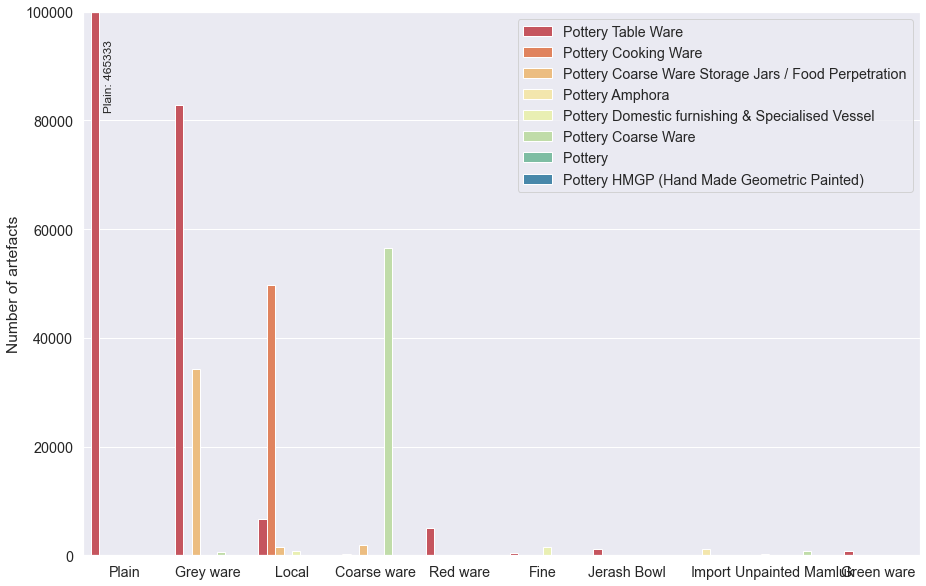

In [76]:
#tableWare = df_NoPlain[df_NoPlain['Type_verbose'].str.contains('Cooking Ware')]
order = df_f.groupby('WareType')["AmountSum"].sum().sort_values(ascending=False)
ware_data = df_f[df_f['WareType'].isin(order[order > 500].index)]

plt.figure(figsize = (15,10))
ax= sns.barplot(x = 'WareType', y = 'AmountSum', hue = 'Type_high_verbose_simplified', estimator = sum, ci = None, order = order[order > 500].index, data = ware_data)
ax.legend(title = '', loc = 1)
ax.set_ylabel('Number of artefacts')
ax.set_xlabel('')
plt.ylim(None, 100000)
plt.text(-0.25, 82000, 'Plain: 465333', rotation = 90, fontsize=12)
#ax.set_xscale("log")

plt.savefig("figures/15.png", dpi = 600, bbox_inches = "tight")

In [77]:
df_f.groupby(['WareType', 'Type_high_verbose_simplified'])['AmountSum'].sum()

WareType          Type_high_verbose_simplified                        
ARSW              Pottery Cooking Ware                                      1
                  Pottery Table Ware                                      177
Abbasid           Pottery Table Ware                                      122
Almagro 50        Pottery Amphora                                         314
Amphora           Pottery Amphora                                          67
                                                                         ... 
Turquoise glazed  Pottery Table Ware                                       44
Unpainted Mamluk  Pottery Coarse Ware                                     823
                  Pottery Coarse Ware Storage Jars / Food Perpetration      6
                  Pottery Cooking Ware                                     37
                  Pottery Table Ware                                      288
Name: AmountSum, Length: 79, dtype: int64

## Distribution of pottery type by chronology

X-axis: Number of artefacts divided by chronology. Note this is on a log scale.; Y-axis: Type of pottery.

Text(0.5, 1.0, 'Pottery types distribution without plain wares')

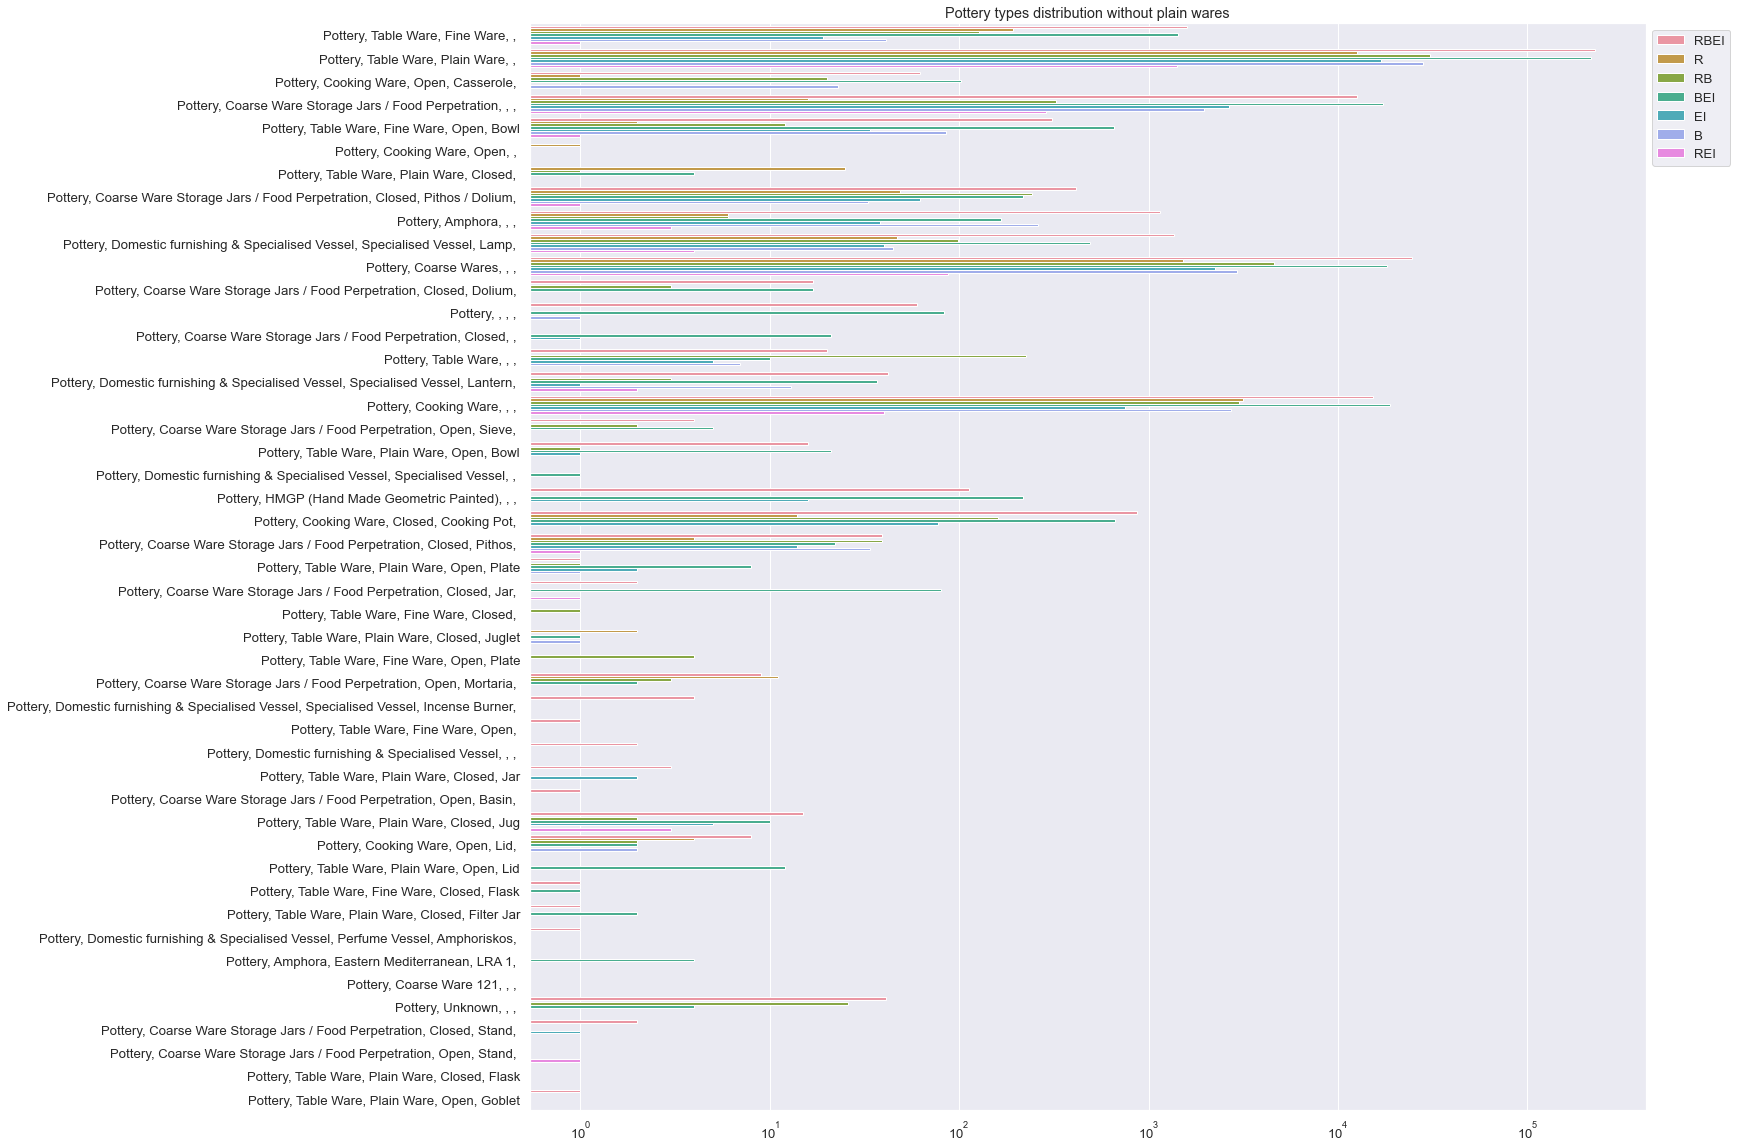

In [78]:
sns.set(palette = 'Spectral', font_scale = 1.2)
plt.figure(figsize = (20,20))
ax = sns.barplot(y = 'Type_verbose', 
                 x = 'AmountSum', 
                 hue = 'Pottery', 
                 data = df_f,
                 estimator= sum, 
                 ci = None)
ax.set(xlabel='', ylabel = '') 
ax.set_xscale("log")
plt.legend(bbox_to_anchor=(1.0, 1), loc=2)

plt.title('Pottery types distribution without plain wares')

## Change over time in pottery functional types (common, distinctive)


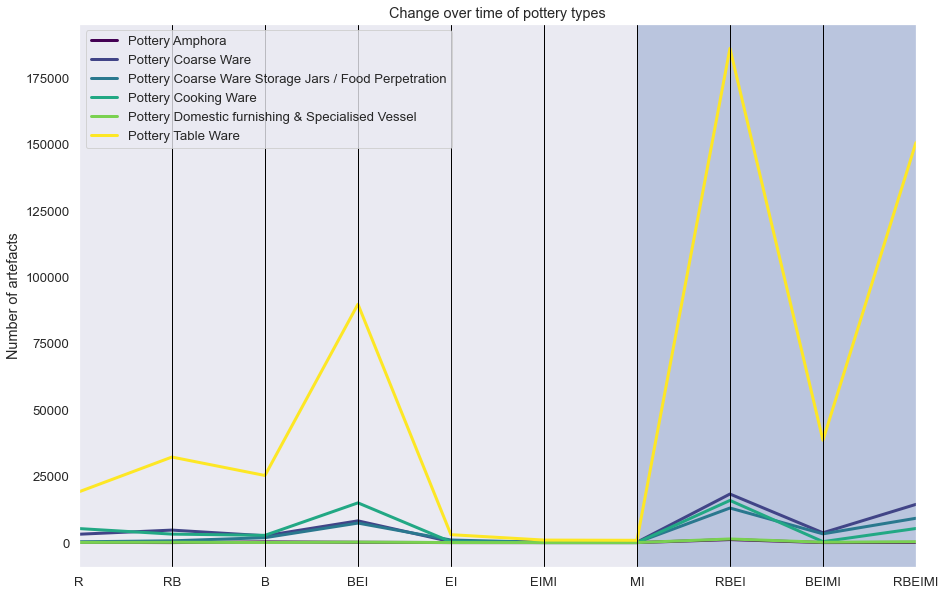

In [79]:

order = df_f.groupby('Type_high_verbose_simplified')["AmountSum"].sum().sort_values(ascending=False)
flow_data = df_f[df_f['Type_high_verbose_simplified'].isin(order[order > 500].index)]
flow_data = flow_data.pivot_table(columns = ['Type_high_verbose_simplified'], index = ["combined"],values = 'AmountSum', aggfunc = sum).T.reset_index()
flow_data = flow_data[['Type_high_verbose_simplified', 'R', 'RB', 'B', 'BEI',  'EI', 'EIMI','MI', 'RBEI', 'BEIMI', 'RBEIMI']].fillna(0)

# Make the plot
fig = plt.figure(figsize=(15,10))
parallel_coordinates(flow_data, 'Type_high_verbose_simplified', colormap = 'viridis', linewidth = 3)

plt.axvspan(xmin = 6, xmax = 9,  facecolor='b', alpha=0.3)
plt.ylabel('Number of artefacts')
plt.title('Change over time of pottery types')
plt.legend(bbox_to_anchor=(0.0, 1), loc=2)

plt.show()

This is figure 14 in Romanowska et al. 2021. Trends in Ceramic Assemblages from the Northwest Quarter of Gerasa/Jerash, Jordan.

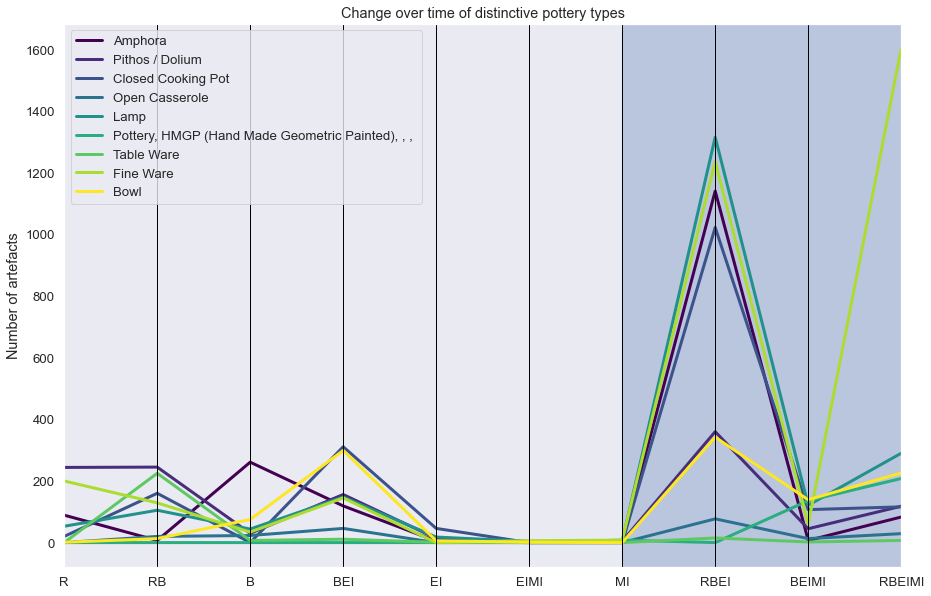

In [80]:
import re
order = df_NoPlain2.groupby('Type_verbose')["AmountSum"].sum().sort_values(ascending=False)

distinctive_data = df_NoPlain2[df_NoPlain2['Type_verbose'].isin(order[order > 200].index)]


flow_data = distinctive_data.pivot_table(columns = ['Type_verbose'], 
                                         index = ["combined"],
                                         values = 'AmountSum', 
                                         aggfunc = sum).T.reset_index()
flow_data = flow_data[['Type_verbose', 'R', 'RB', 'B', 'BEI',  'EI', 'EIMI','MI', 'RBEI', 'BEIMI', 'RBEIMI']].fillna(0)
change_dic = {'Pottery, Amphora, , , ': 'Amphora',
 'Pottery, Coarse Ware Storage Jars / Food Perpetration, Closed, Pithos / Dolium, ':"Pithos / Dolium",
 'Pottery, Cooking Ware, Closed, Cooking Pot, ': "Closed Cooking Pot",
 'Pottery, Cooking Ware, Open, Casserole, ':"Open Casserole",
 'Pottery, Domestic furnishing & Specialised Vessel, Specialised Vessel, Lamp, ':"Lamp",
 'Pottery, Table Ware, , , ':"Table Ware",
 'Pottery, Table Ware, Fine Ware, , ':'Fine Ware',
 'Pottery, Table Ware, Fine Ware, Open, Bowl':'Bowl'}
flow_data.Type_verbose =flow_data.Type_verbose.replace(change_dic)
# Make the plot
fig = plt.figure(figsize=(15,10))
parallel_coordinates(flow_data, 'Type_verbose', colormap = 'viridis', linewidth = 3)
#parallel_coordinates(flow_data, flow_data.index, colormap=plt.get_cmap("Set2"))

plt.axvspan(xmin = 6, xmax = 9,  facecolor='b', alpha=0.3)
plt.ylabel('Number of artefacts')
plt.title('Change over time of distinctive pottery types')
plt.legend(bbox_to_anchor=(0.0, 1), loc=2)

plt.savefig('figures/14.png', dpi = 600, bbox_inches = "tight")
plt.show()

### Distribution of pottery provenance between higher level pottery types 

X-axis: Pottery types (High level division) ; Y-axis: proportion of artefacts.


This is figure 3 in Romanowska et al. 2021. A study of the centuries-long reliance on local ceramics in Jerash through full quantification and simulation.

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

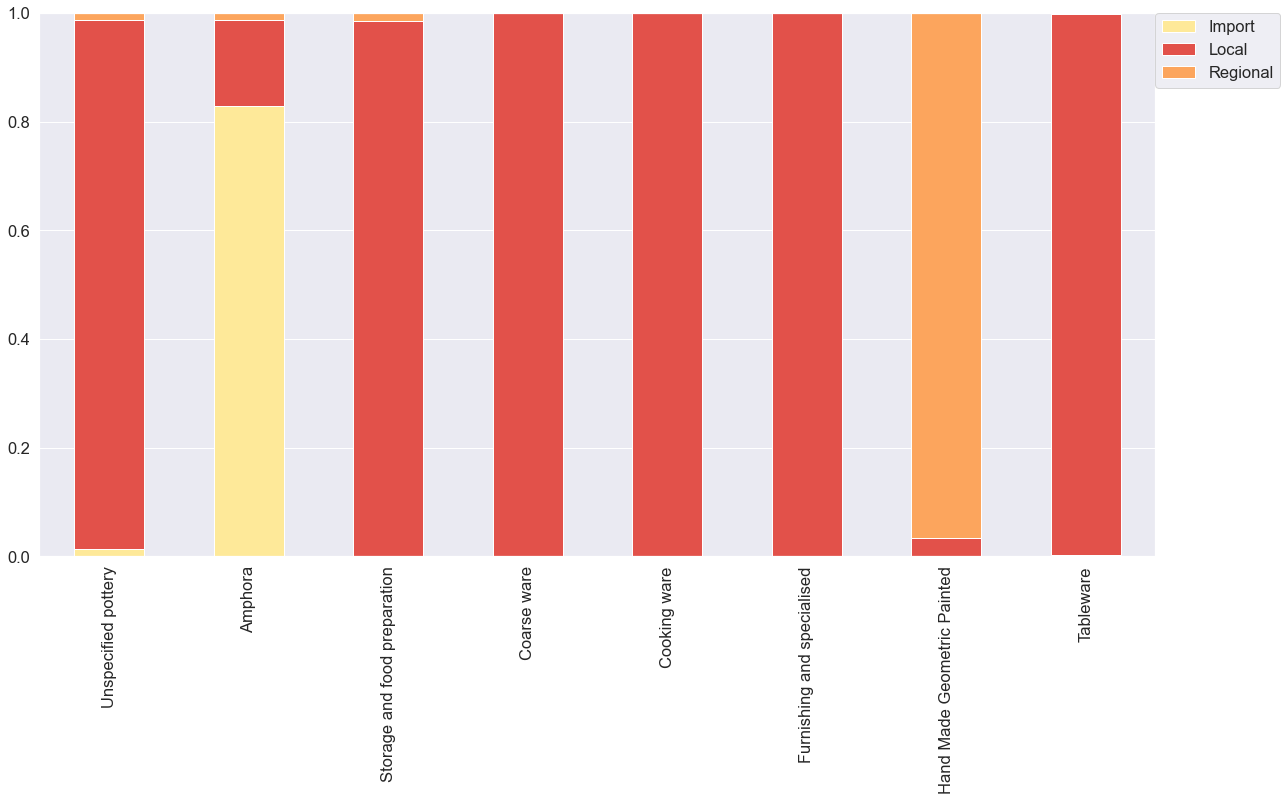

In [81]:
sns.set( font_scale = 1.5)
sns.set_palette(pal)

# the pottery designation is taken from the top two levels and we merged 'Pottery' and 'Pottery Unknown', thus -"simiplified"
ax = (df_f.groupby(['Type_high_verbose_simplified','Local'])["AmountSum"]
              .sum()                             # sum amounts per trench per evidence
              .unstack()                         # crt the data frame
              .T                                 # transpose
              .apply(lambda x: x / x.sum())      # calculate frequencies per evidence
              .T                                 # transpose back (there must be a better way...)
              .plot(kind='bar',                  # plot
                  stacked=True, 
                  figsize = (20,10)))
plt.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0., ncol = 1)
plt.ylim([0,1])
ax.set(xlabel='')
ax.set_xticklabels(['Unspecified pottery', 'Amphora', 'Storage and food preparation', 'Coarse ware', 'Cooking ware', 'Furnishing and specialised', 'Hand Made Geometric Painted', 'Tableware'])
#plt.title("")
plt.xticks(rotation = 90)
#plt.savefig('CiC_Local_Pot_type_loc_sim.png', dpi = 600, bbox_inches = "tight")
# df_f.groupby(['Type_high_verbose_simplified','Local'])["AmountSum"].sum()

Note: this is virtually the same with or without the plain wares; only the scale on the y axis is different - it's in tens of thousands not hundreds of thousands. 

## Chronology of trenches
X-axis: Trench; Y-axis: Number of artefacts within dated contexts.


Text(0.5, 1.0, 'Dating by trench')

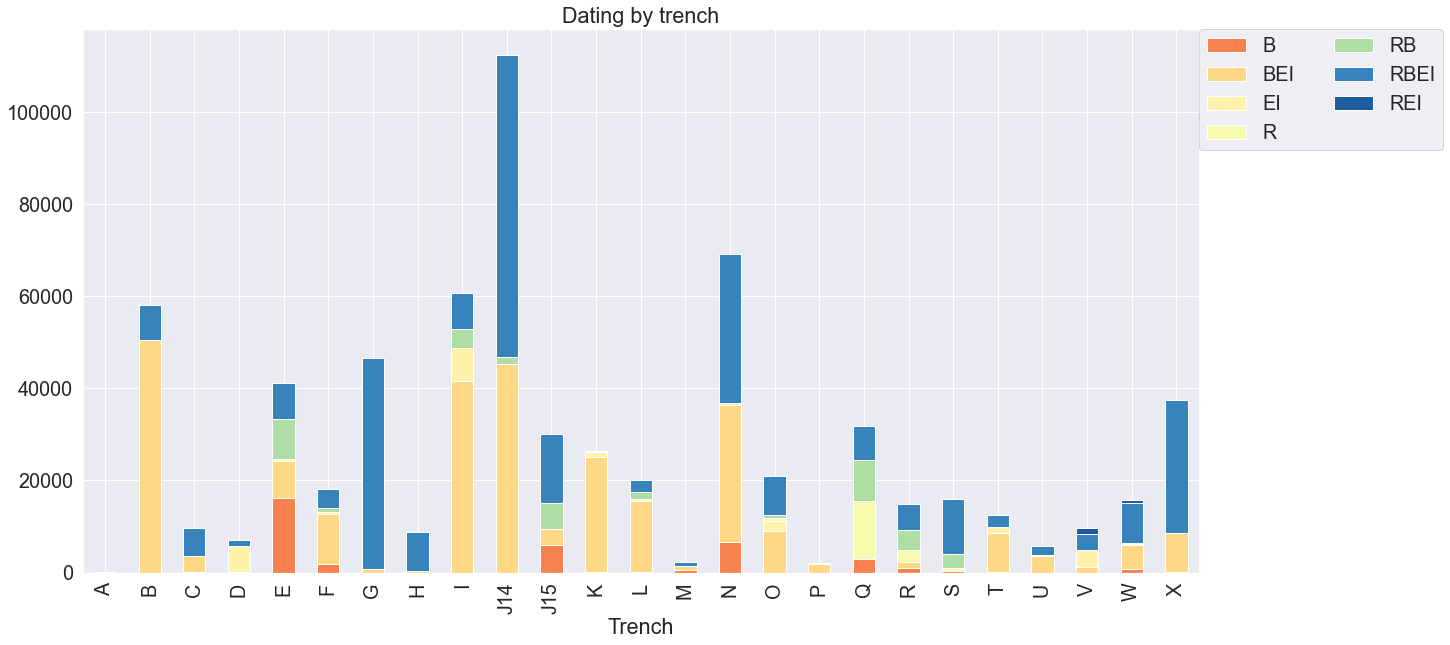

In [82]:
from matplotlib.colors import ListedColormap

sns.set(font_scale = 1.8)
chrono_cmap = ListedColormap(pal_chrono)
evid = (df_f.groupby(['Trench','Pottery'])["AmountSum"]
        .sum()
        .unstack()
        .plot(kind='bar', 
              stacked=True, 
              colormap = chrono_cmap,
              figsize = (20,10)))
#sns.barplot(x = 'Trench', hue= evid.columns[1:], data = evid)
plt.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0., ncol = 2)
plt.title('Dating by trench')

#plt.xticks(rotation = 90)

### Stacked barplots showing frequencies of dates

X-axis: Trench; Y-axis: Proportion of artefacts within dated contexts.


(0.0, 1.0)

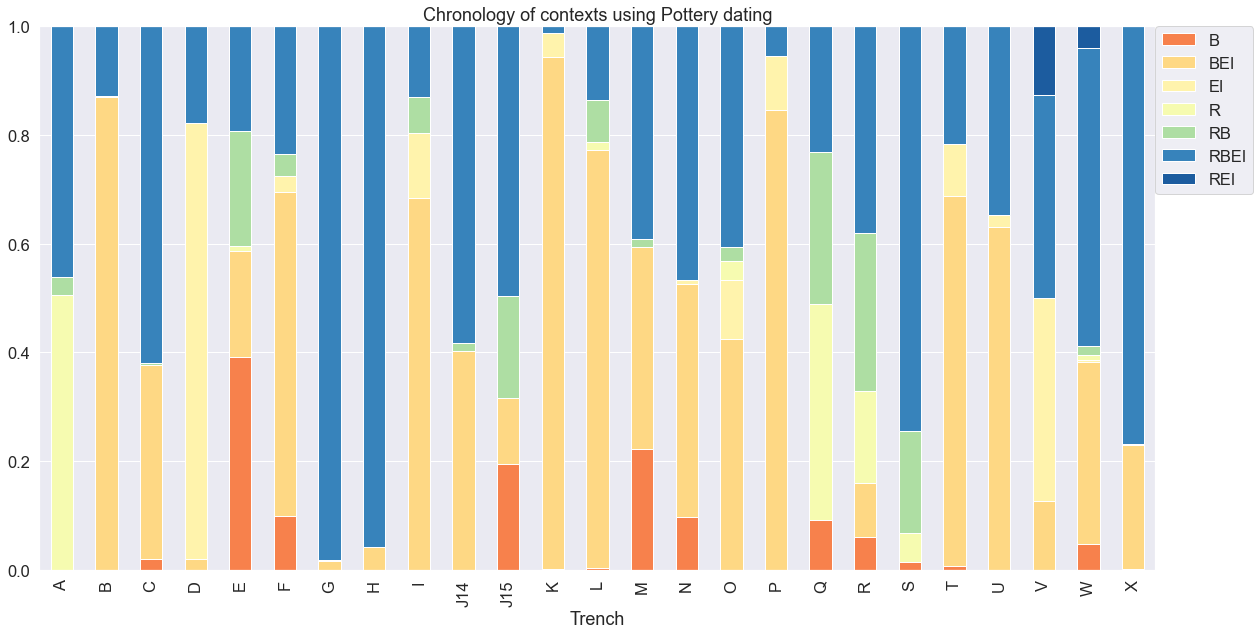

In [83]:
sns.set(font_scale=1.5)


freqs_evid = (df_f.groupby(['Trench','Pottery'])["AmountSum"]
              .sum()                             # sum amounts per trench per evidence
              .unstack()                         # crt the data frame
              .T                                 # transpose
              .apply(lambda x: x / x.sum())      # calculate frequencies per evidence
              .T                                 # transpose back
              .plot(kind='bar',                  # plot
                  stacked=True, 
                  colormap = chrono_cmap,
                  figsize = (20,10)))
plt.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0., ncol = 1)
plt.title('Chronology of contexts using Pottery dating')
plt.ylim([0,1])
#plt.savefig('CiC_chronology_trenches.png', dpi = 600)

### Trench chronology without long chronology contexts

This is figure 7 in Romanowska et al. 2021. Trends in Ceramic Assemblages from the Northwest Quarter of Gerasa/Jerash, Jordan.

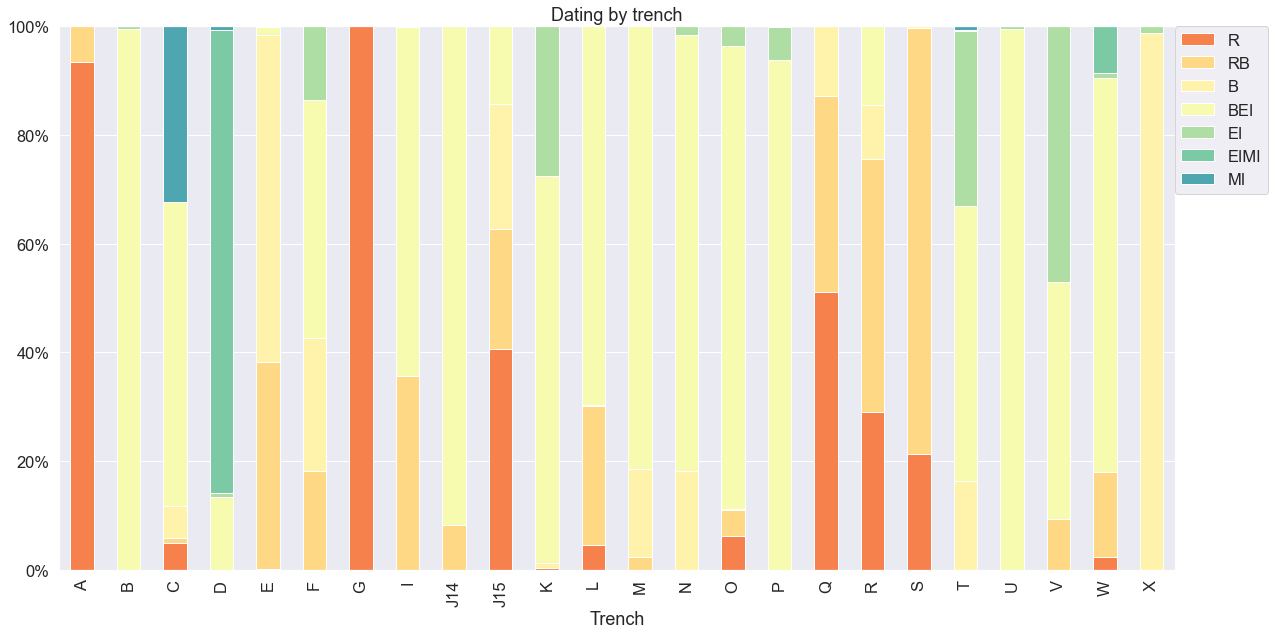

In [84]:
pal_chrono_cmap = ListedColormap(pal_chrono_all[:-3])
order = [ 'R', 'RB', 'B', 'BEI',  'EI', 'REI','RBEI', 'no dating']
test = df_f.pivot_table(columns = 'Trench', index = 'combined', values = 'AmountSum', aggfunc = sum).fillna(0)#

test = test.rename(index={'':'no dating'}).reindex(all_order[:-3]).drop(["Qbd", "Qg", "Qh",'H'], axis = 1)
ax = test.iloc[:,:].apply(lambda x: x / x.sum()).T.plot(
                                         kind='bar',     
                                         colormap = pal_chrono_cmap,
                                         figsize = (20,10),# plot
                                         stacked=True)
ax.set_yticklabels([str(x) +'%' for x in range(0,101,20)])
plt.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0., ncol = 1)
plt.title('Dating by trench')
plt.ylim([0,1])
plt.savefig('figures/7.png', dpi = 600, bbox_inches = "tight")

### Part of the object: pottery preservation

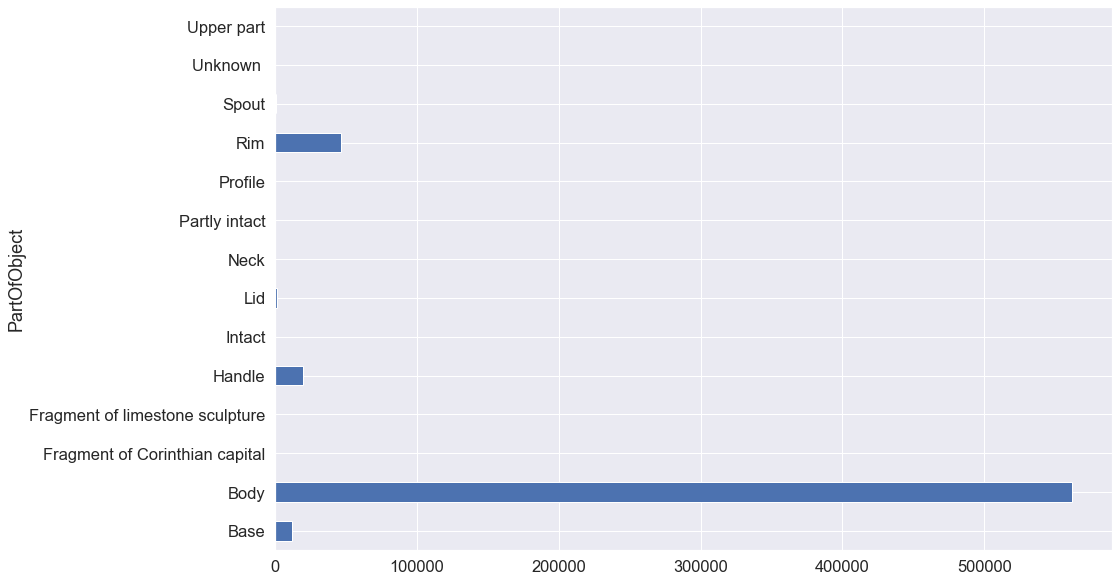

In [85]:
plt.figure (figsize = (15, 10))
df_clean.groupby('PartOfObject')['AmountSum'].sum().plot(kind = 'barh')
#plt.xscale("log")

In [86]:
right = df_clean.groupby('PartOfObject')['AmountSum'].sum().apply(lambda x: x/df_clean.AmountSum.sum()*100)
left = df_clean.groupby('PartOfObject')['AmountSum'].sum()
PoO = pd.merge(left.to_frame(), right.to_frame(), left_index = True, right_index = True).reset_index() 
PoO = PoO.rename(columns = {'AmountSum_x':'Number of Artefacts','AmountSum_y': 'Percentage'})
PoO

,PartOfObject,Number of Artefacts,Percentage
0,Base,12134,1.890205
1,Body,562001,87.547142
2,Fragment of Corinthian capital,4,0.000623
3,Fragment of limestone sculpture,1,0.000156
4,Handle,19650,3.061029
5,Intact,6,0.000935
6,Lid,1039,0.161853
7,Neck,1,0.000156
8,Partly intact,1,0.000156
9,Profile,88,0.013708


### Pottery preservation main categories
This is figure 16 in Romanowska et al. 2021. Trends in Ceramic Assemblages from the Northwest Quarter of Gerasa/Jerash, Jordan.

C:\Users\au680564\Anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


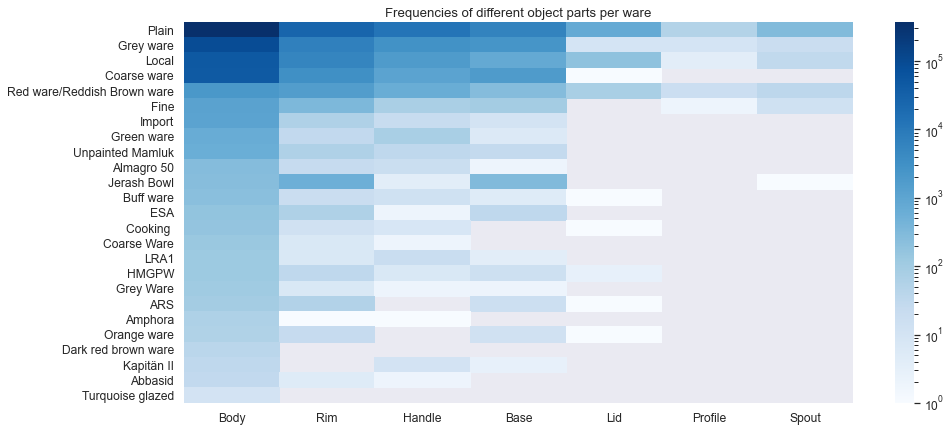

In [87]:
from matplotlib.colors import LogNorm
import math
sns.set(font_scale = 1.1)
# Data preparation
ct_preservation =pd.pivot_table(data = df_clean, values = 'AmountSum', index = "PartOfObject", columns = "WareType", aggfunc = sum).T
# change 'WareType' to SG2, SG3 to see the distribution for functional types
# Remove categories that are less than 10
big_r = ct_preservation.apply(np.mean, axis = 1) > 10
big_c = ct_preservation.apply(np.mean, axis = 0) > 10
b_ct_pre = ct_preservation[big_r]
b_ct_pre = b_ct_pre.loc[:, big_c]
# Reorder the data so that the visualisation is easier to read
b_ct_pre = b_ct_pre[['Body', 'Rim', 'Handle', 'Base', 'Lid', 'Profile', 'Spout']]
b_ct_pre = b_ct_pre.sort_values(by='Body', ascending=0)

# plotting
plt.figure(figsize=(15,7))

# The difference between the body and the rest is so large that the visualisation on a standard scale is meaningless. 
# Thus the colors are set on a log scale. Note, because the min of AmountSum was zero we added 1 when scaling the color scale (this makes virtually no difference in the shades). 
log_norm = LogNorm(vmin=df_clean.AmountSum.min(), vmax=df_clean.AmountSum.max())
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(df_clean.AmountSum.min()+1)), 1+math.ceil(math.log10(df_clean.AmountSum.max())))]

sns.heatmap(b_ct_pre, cmap='Blues', norm=log_norm, cbar_kws={"ticks": cbar_ticks})
plt.xlabel("") 
plt.ylabel("")
plt.title("Frequencies of different object parts per ware")
plt.savefig('figures/16.png', dpi = 600, bbox_inches = "tight")

FIN